In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

In [3]:
def get_matching_columns(gps_mpu_left,gps_mpu_right,left_key,right_key):
    matching_columns = []

    gps_mpu_merged = pd.merge(
        gps_mpu_left, gps_mpu_right,
        left_on=left_key, right_on=right_key, how='inner'
    )

    gps_mpu_merged['timestamp_match'] = gps_mpu_merged[left_key] == gps_mpu_merged[right_key]
    matching_count = gps_mpu_merged['timestamp_match'].sum()
    
    if matching_count == len(gps_mpu_merged):
        #gps_mpu_merged['timestamp_match'] = gps_mpu_PV2[left_key]
        #gps_mpu_merged.drop(columns=[left_key,right_key],inplace = True)
        for col in gps_mpu_merged.columns:
            if col.endswith('_left') and col.replace('_left', '_right') in gps_mpu_merged.columns:
                left_col = col
                right_col = col.replace('_left', '_right')

                if (gps_mpu_merged[left_col] == gps_mpu_merged[right_col]).all():
                    matching_columns.append(col.replace('_left', ''))

    return matching_columns,gps_mpu_merged

In [4]:
def Correc_Datos(df_original,df_config):
    for axis in ['x','y','z']:
        df_original[f'gyro_{axis}_dashboard_right'] = (df_original[f'gyro_{axis}_dashboard_right'] + df_config[f'gyroscope_bias_{axis}_right'].values[0])
        df_original[f'gyro_{axis}_dashboard_left'] = (df_original[f'gyro_{axis}_dashboard_left'] + df_config[f'gyroscope_bias_{axis}_left'].values[0])
        df_original[f'gyro_{axis}_above_suspension_left'] = (df_original[f'gyro_{axis}_above_suspension_left'] + df_config[f'gyroscope_bias_{axis}_left'].values[1])
        df_original[f'gyro_{axis}_above_suspension_right'] = (df_original[f'gyro_{axis}_above_suspension_right'] + df_config[f'gyroscope_bias_{axis}_right'].values[1])
        df_original[f'gyro_{axis}_below_suspension_left'] = (df_original[f'gyro_{axis}_below_suspension_left'] + df_config[f'gyroscope_bias_{axis}_left'].values[2])
        df_original[f'gyro_{axis}_below_suspension_right'] = (df_original[f'gyro_{axis}_below_suspension_right'] + df_config[f'gyroscope_bias_{axis}_right'].values[2])
        df_original[f'acc_{axis}_dashboard_right'] = (df_original[f'acc_{axis}_dashboard_right'] + df_config[f'accelerometer_bias_{axis}_right'].values[0])
        df_original[f'acc_{axis}_dashboard_left'] = (df_original[f'acc_{axis}_dashboard_left'] + df_config[f'accelerometer_bias_{axis}_left'].values[0])
        df_original[f'acc_{axis}_above_suspension_left'] = (df_original[f'acc_{axis}_above_suspension_left'] + df_config[f'accelerometer_bias_{axis}_left'].values[1])
        df_original[f'acc_{axis}_above_suspension_right'] = (df_original[f'acc_{axis}_above_suspension_right'] + df_config[f'accelerometer_bias_{axis}_right'].values[1])
        df_original[f'acc_{axis}_below_suspension_left'] = (df_original[f'acc_{axis}_below_suspension_left'] + df_config[f'accelerometer_bias_{axis}_left'].values[2])
        df_original[f'acc_{axis}_below_suspension_right'] = (df_original[f'acc_{axis}_below_suspension_right'] + df_config[f'accelerometer_bias_{axis}_right'].values[2])

    return df_original



In [5]:
def Calcular_Vel_Ang(df):
    prefixes = [
    'dashboard_left', 'dashboard_right',
    'above_suspension_left', 'above_suspension_right',
    'below_suspension_left', 'below_suspension_right'
    ]
    sum_x = np.zeros(len(df))
    sum_y = np.zeros(len(df))
    sum_z = np.zeros(len(df))
    
    for prefix in prefixes:
        x_col = f'gyro_x_{prefix}'
        y_col = f'gyro_y_{prefix}'
        z_col = f'gyro_z_{prefix}'
        
        if x_col in df.columns and y_col in df.columns and z_col in df.columns:
            sum_x += df[x_col]
            sum_y += df[y_col]
            sum_z += df[z_col]
    
    
    num_prefijos = len(prefixes)
    df['gyro_x_avg'] = sum_x / num_prefijos
    df['gyro_y_avg'] = sum_y / num_prefijos
    df['gyro_z_avg'] = sum_z / num_prefijos
    
    df['gyro_magnitude_avg'] = np.sqrt(df['gyro_x_avg']**2 + df['gyro_y_avg']**2 + df['gyro_z_avg']**2)
    
    return df
    

In [6]:
def Calcular_Acel(df):
    prefixes = [
    'dashboard_left', 'dashboard_right',
    'above_suspension_left', 'above_suspension_right',
    'below_suspension_left', 'below_suspension_right'
    ]
    sum_x = np.zeros(len(df))
    sum_y = np.zeros(len(df))
    sum_z = np.zeros(len(df))

    for prefix in prefixes:
        x_col = f'acc_x_{prefix}'
        y_col = f'acc_y_{prefix}'
        z_col = f'acc_z_{prefix}'
        
        if x_col in df.columns and y_col in df.columns and z_col in df.columns:
            sum_x += df[x_col]
            sum_y += df[y_col]
            sum_z += df[z_col]
    
    
    num_prefijos = len(prefixes)
    df['acc_x_avg'] = sum_x / num_prefijos
    df['acc_y_avg'] = sum_y / num_prefijos
    df['acc_z_avg'] = sum_z / num_prefijos
    
    # Calcular la magnitud de la aceleración promedio
    df['acc_magnitude_avg'] = np.sqrt(df['acc_x_avg']**2 + df['acc_y_avg']**2 + df['acc_z_avg']**2)
    
    return df

In [7]:
df = pd.read_csv('PVS 1/dataset_gps_mpu_left.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   timestamp                144036 non-null  float64
 1   acc_x_dashboard          144036 non-null  float64
 2   acc_y_dashboard          144036 non-null  float64
 3   acc_z_dashboard          144036 non-null  float64
 4   acc_x_above_suspension   144036 non-null  float64
 5   acc_y_above_suspension   144036 non-null  float64
 6   acc_z_above_suspension   144036 non-null  float64
 7   acc_x_below_suspension   144036 non-null  float64
 8   acc_y_below_suspension   144036 non-null  float64
 9   acc_z_below_suspension   144036 non-null  float64
 10  gyro_x_dashboard         144036 non-null  float64
 11  gyro_y_dashboard         144036 non-null  float64
 12  gyro_z_dashboard         144036 non-null  float64
 13  gyro_x_above_suspension  144036 non-null  float64
 14  gyro

PV1

In [9]:
gps = pd.read_csv('PVS 1/dataset_gps.csv')
gps_mpu_left = pd.read_csv('PVS 1/dataset_gps_mpu_left.csv')
gps_mpu_right = pd.read_csv('PVS 1/dataset_gps_mpu_right.csv')

In [10]:
gps_mpu_left.columns = [col+'_left' for col in gps_mpu_left.columns]
gps_mpu_right.columns = [col+'_right' for col in gps_mpu_right.columns]

In [11]:
gps_mpu_left.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp_left                144036 non-null  float64
 1   acc_x_dashboard_left          144036 non-null  float64
 2   acc_y_dashboard_left          144036 non-null  float64
 3   acc_z_dashboard_left          144036 non-null  float64
 4   acc_x_above_suspension_left   144036 non-null  float64
 5   acc_y_above_suspension_left   144036 non-null  float64
 6   acc_z_above_suspension_left   144036 non-null  float64
 7   acc_x_below_suspension_left   144036 non-null  float64
 8   acc_y_below_suspension_left   144036 non-null  float64
 9   acc_z_below_suspension_left   144036 non-null  float64
 10  gyro_x_dashboard_left         144036 non-null  float64
 11  gyro_y_dashboard_left         144036 non-null  float64
 12  gyro_z_dashboard_left         144036 non-nul

In [12]:
gps_mpu_right.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   timestamp_right                144036 non-null  float64
 1   acc_x_dashboard_right          144036 non-null  float64
 2   acc_y_dashboard_right          144036 non-null  float64
 3   acc_z_dashboard_right          144036 non-null  float64
 4   acc_x_above_suspension_right   144036 non-null  float64
 5   acc_y_above_suspension_right   144036 non-null  float64
 6   acc_z_above_suspension_right   144036 non-null  float64
 7   acc_x_below_suspension_right   144036 non-null  float64
 8   acc_y_below_suspension_right   144036 non-null  float64
 9   acc_z_below_suspension_right   144036 non-null  float64
 10  gyro_x_dashboard_right         144036 non-null  float64
 11  gyro_y_dashboard_right         144036 non-null  float64
 12  gyro_z_dashboard_right        

In [13]:
gps_mpu = pd.merge(gps_mpu_left,gps_mpu_right,left_on='timestamp_left', right_on='timestamp_right', how='inner')#Combinamos los dataframe
                                                                                                 # pero conservando las caracteristicas

In [14]:
gps_mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 64 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   timestamp_left                 144036 non-null  float64
 1   acc_x_dashboard_left           144036 non-null  float64
 2   acc_y_dashboard_left           144036 non-null  float64
 3   acc_z_dashboard_left           144036 non-null  float64
 4   acc_x_above_suspension_left    144036 non-null  float64
 5   acc_y_above_suspension_left    144036 non-null  float64
 6   acc_z_above_suspension_left    144036 non-null  float64
 7   acc_x_below_suspension_left    144036 non-null  float64
 8   acc_y_below_suspension_left    144036 non-null  float64
 9   acc_z_below_suspension_left    144036 non-null  float64
 10  gyro_x_dashboard_left          144036 non-null  float64
 11  gyro_y_dashboard_left          144036 non-null  float64
 12  gyro_z_dashboard_left         

In [15]:
gps_mpu['timestamp'] = gps_mpu['timestamp_left'] == gps_mpu['timestamp_right']

In [16]:
matching_count = gps_mpu['timestamp'].sum()

In [17]:
matching_count #Podemos ver que los timestamp coinciden por lo que podemos dejar un solo timestamo

np.int64(144036)

In [18]:
gps_mpu['timestamp'] = gps_mpu['timestamp_left']

In [19]:
gps_mpu.drop(columns=['timestamp_left','timestamp_right'],inplace = True)

In [20]:
gps_mpu

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp_gps_right,latitude_right,longitude_right,speed_right,timestamp
0,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,-0.133896,...,14.911350,-14.487265,34.274628,34.035014,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,1.577219e+09
1,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,-0.027084,...,13.572675,-13.254307,34.346512,33.891245,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,1.577219e+09
2,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,0.125504,...,13.498305,-12.637827,34.370474,34.274628,31.543026,1.577219e+09,-27.717841,-51.098865,0.009128,1.577219e+09
3,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,-0.088120,...,13.498305,-12.637827,34.370474,33.939168,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,1.577219e+09
4,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,-0.179672,...,14.688238,-15.103745,34.370474,33.939168,30.967952,1.577219e+09,-27.717841,-51.098865,0.009128,1.577219e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-0.527921,-0.322918,9.583271,-0.331976,-0.185200,9.528076,-0.704237,-0.054839,9.753122,-0.332260,...,-0.818079,-80.758798,32.884865,40.552520,33.244287,1.577220e+09,-27.717777,-51.099070,0.005715,1.577220e+09
144032,-0.663194,-0.575506,9.433633,-0.458869,-0.413847,10.223591,-0.748530,-0.212856,9.526870,-0.240707,...,-0.557781,-82.299997,32.884865,40.504598,33.172402,1.577220e+09,-27.717777,-51.099070,0.005715,1.577220e+09
144033,-0.375890,-0.245106,9.957964,-0.104527,-0.047534,9.687290,-0.719800,-0.150607,9.933885,0.064468,...,-2.565793,-84.149435,32.836943,40.600443,33.316171,1.577220e+09,-27.717777,-51.099070,0.005715,1.577220e+09
144034,-0.385466,-0.091877,9.840648,-0.530695,-0.452154,8.940299,-0.705434,-0.378056,10.003317,-0.423813,...,-2.008012,-79.525840,32.980711,40.600443,33.100518,1.577220e+09,-27.717777,-51.099070,0.005715,1.577220e+09


In [21]:
gps_mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 63 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           144036 non-null  float64
 1   acc_y_dashboard_left           144036 non-null  float64
 2   acc_z_dashboard_left           144036 non-null  float64
 3   acc_x_above_suspension_left    144036 non-null  float64
 4   acc_y_above_suspension_left    144036 non-null  float64
 5   acc_z_above_suspension_left    144036 non-null  float64
 6   acc_x_below_suspension_left    144036 non-null  float64
 7   acc_y_below_suspension_left    144036 non-null  float64
 8   acc_z_below_suspension_left    144036 non-null  float64
 9   gyro_x_dashboard_left          144036 non-null  float64
 10  gyro_y_dashboard_left          144036 non-null  float64
 11  gyro_z_dashboard_left          144036 non-null  float64
 12  gyro_x_above_suspension_left  

In [22]:
matching_columns = []

for col in gps_mpu.columns:
    if col.endswith('_left') and col.replace('_left', '_right') in gps_mpu.columns:
        left_col = col
        right_col = col.replace('_left','_right')

        if (gps_mpu[left_col] == gps_mpu[right_col]).all():
            matching_columns.append(col.replace('_left', ''))

In [23]:
matching_columns # Las columnas que coinciden son:

['timestamp_gps', 'latitude', 'longitude', 'speed']

In [24]:
gps_mpu['timestamp_gps'] = gps_mpu['timestamp_gps_left']
gps_mpu['latitude'] = gps_mpu['latitude_left']
gps_mpu['longitude'] = gps_mpu['longitude_left']
gps_mpu['speed'] = gps_mpu['speed_left']

In [25]:
gps_mpu.drop(columns=['timestamp_gps_left','timestamp_gps_right','latitude_left','latitude_right','longitude_left','longitude_right','speed_left','speed_right'],inplace = True)

In [26]:
gps_mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           144036 non-null  float64
 1   acc_y_dashboard_left           144036 non-null  float64
 2   acc_z_dashboard_left           144036 non-null  float64
 3   acc_x_above_suspension_left    144036 non-null  float64
 4   acc_y_above_suspension_left    144036 non-null  float64
 5   acc_z_above_suspension_left    144036 non-null  float64
 6   acc_x_below_suspension_left    144036 non-null  float64
 7   acc_y_below_suspension_left    144036 non-null  float64
 8   acc_z_below_suspension_left    144036 non-null  float64
 9   gyro_x_dashboard_left          144036 non-null  float64
 10  gyro_y_dashboard_left          144036 non-null  float64
 11  gyro_z_dashboard_left          144036 non-null  float64
 12  gyro_x_above_suspension_left  

In [27]:
gps_mpu

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp,timestamp_gps,latitude,longitude,speed
0,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,-0.133896,...,14.911350,-14.487265,34.274628,34.035014,31.926408,1.577219e+09,1.577219e+09,-27.717841,-51.098865,0.009128
1,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,-0.027084,...,13.572675,-13.254307,34.346512,33.891245,31.926408,1.577219e+09,1.577219e+09,-27.717841,-51.098865,0.009128
2,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,0.125504,...,13.498305,-12.637827,34.370474,34.274628,31.543026,1.577219e+09,1.577219e+09,-27.717841,-51.098865,0.009128
3,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,-0.088120,...,13.498305,-12.637827,34.370474,33.939168,31.926408,1.577219e+09,1.577219e+09,-27.717841,-51.098865,0.009128
4,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,-0.179672,...,14.688238,-15.103745,34.370474,33.939168,30.967952,1.577219e+09,1.577219e+09,-27.717841,-51.098865,0.009128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-0.527921,-0.322918,9.583271,-0.331976,-0.185200,9.528076,-0.704237,-0.054839,9.753122,-0.332260,...,-0.818079,-80.758798,32.884865,40.552520,33.244287,1.577220e+09,1.577220e+09,-27.717777,-51.099070,0.005715
144032,-0.663194,-0.575506,9.433633,-0.458869,-0.413847,10.223591,-0.748530,-0.212856,9.526870,-0.240707,...,-0.557781,-82.299997,32.884865,40.504598,33.172402,1.577220e+09,1.577220e+09,-27.717777,-51.099070,0.005715
144033,-0.375890,-0.245106,9.957964,-0.104527,-0.047534,9.687290,-0.719800,-0.150607,9.933885,0.064468,...,-2.565793,-84.149435,32.836943,40.600443,33.316171,1.577220e+09,1.577220e+09,-27.717777,-51.099070,0.005715
144034,-0.385466,-0.091877,9.840648,-0.530695,-0.452154,8.940299,-0.705434,-0.378056,10.003317,-0.423813,...,-2.008012,-79.525840,32.980711,40.600443,33.100518,1.577220e+09,1.577220e+09,-27.717777,-51.099070,0.005715


In [28]:
mpu_left = pd.read_csv('PVS 1/dataset_mpu_left.csv')
mpu_right = pd.read_csv('PVS 1/dataset_mpu_right.csv')

In [29]:
mpu_left.columns = [col+'_left' for col in mpu_left.columns]
mpu_right.columns = [col+'_right' for col in mpu_right.columns]

In [30]:
mpu_right

,timestamp_right,acc_x_dashboard_right,acc_y_dashboard_right,acc_z_dashboard_right,acc_x_above_suspension_right,acc_y_above_suspension_right,acc_z_above_suspension_right,acc_x_below_suspension_right,acc_y_below_suspension_right,acc_z_below_suspension_right,...,gyro_z_below_suspension_right,mag_x_dashboard_right,mag_y_dashboard_right,mag_z_dashboard_right,mag_x_above_suspension_right,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right
0,1.577219e+09,0.314897,0.187227,9.863572,0.314750,0.166426,9.808869,0.529819,0.097111,9.930623,...,0.000186,21.269188,-5.267097,1.003341,119.994669,14.911350,-14.487265,34.274628,34.035014,31.926408
1,1.577219e+09,0.316094,0.175256,9.846813,0.343480,0.135302,9.854359,0.522637,0.097111,9.923440,...,-0.121884,21.352596,-4.596739,2.257518,119.994669,13.572675,-13.254307,34.346512,33.891245,31.926408
2,1.577219e+09,0.278984,0.199198,9.892303,0.283625,0.173609,9.856753,0.527425,0.104294,9.973719,...,0.030704,19.934650,-6.416282,2.006683,117.292086,13.498305,-12.637827,34.370474,34.274628,31.543026
3,1.577219e+09,0.295744,0.194409,9.806111,0.336298,0.161638,9.878301,0.517848,0.099505,9.901893,...,-0.182919,20.268285,-5.650159,1.672236,117.292086,13.498305,-12.637827,34.370474,33.939168,31.926408
4,1.577219e+09,0.322080,0.203986,9.877937,0.329115,0.156849,9.784927,0.548973,0.085140,9.873162,...,-0.182919,21.102371,-6.224751,2.173907,115.130020,14.688238,-15.103745,34.370474,33.939168,30.967952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,1.577220e+09,-0.515891,-0.204225,9.743862,-0.634551,-0.321991,9.605362,-0.532009,-0.129141,9.640925,...,0.229068,-10.342664,-24.132882,3.595307,-20.269370,-0.818079,-80.758798,32.884865,40.552520,33.244287
144032,1.577220e+09,-0.568563,-0.526246,9.408674,-0.523221,-0.068206,10.021953,-0.605032,-0.384123,9.858797,...,-0.274472,-9.258352,-24.994771,3.846142,-23.782727,-0.557781,-82.299997,32.884865,40.504598,33.172402
144033,1.577220e+09,-0.530256,-0.222182,9.858784,-0.506461,-0.130455,9.873512,-0.595455,-0.273990,9.545156,...,-0.427060,-9.091535,-24.037117,4.013366,-17.837045,-2.565793,-84.149435,32.836943,40.600443,33.316171
144034,1.577220e+09,-0.532650,-0.076136,10.052714,-0.469351,-0.416562,9.494031,-0.502082,-0.039358,9.594238,...,0.106998,-9.091535,-24.037117,4.013366,-19.188337,-2.008012,-79.525840,32.980711,40.600443,33.100518


In [31]:
mpu_left

,timestamp_left,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,...,gyro_z_below_suspension_left,mag_x_dashboard_left,mag_y_dashboard_left,mag_z_dashboard_left,mag_x_above_suspension_left,mag_y_above_suspension_left,mag_z_above_suspension_left,temp_dashboard_left,temp_above_suspension_left,temp_below_suspension_left
0,1.577219e+09,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,...,-0.078110,22.878922,-6.040509,1.767874,75.340967,-7.537556,-0.334800,35.065355,33.340132,31.782640
1,1.577219e+09,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,...,0.150771,22.878922,-5.854647,2.089306,75.300243,-6.469241,-5.222873,34.993471,33.172402,31.782640
2,1.577219e+09,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,...,0.028701,23.434686,-4.181891,0.642863,75.463140,-7.893661,-4.687194,34.993471,33.412017,31.926408
3,1.577219e+09,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,...,0.059219,23.990449,-5.482924,1.125011,75.463140,-7.893661,-4.687194,34.969509,33.220325,31.926408
4,1.577219e+09,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,...,0.013442,22.693668,-6.040509,1.928590,74.933726,-8.012363,-4.084555,34.945548,33.220325,31.830563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,1.577220e+09,-0.527921,-0.322918,9.583271,-0.331976,-0.185200,9.528076,-0.704237,-0.054839,9.753122,...,-0.001817,-9.911112,-24.626692,3.375032,74.200691,-42.673250,-16.673019,33.699554,35.568545,32.237907
144032,1.577220e+09,-0.663194,-0.575506,9.433633,-0.458869,-0.413847,10.223591,-0.748530,-0.212856,9.526870,...,0.181289,-9.170094,-23.883244,4.178611,74.648657,-42.554548,-20.489734,33.699554,35.472699,32.309791
144033,1.577220e+09,-0.375890,-0.245106,9.957964,-0.104527,-0.047534,9.687290,-0.719800,-0.150607,9.933885,...,0.089736,-9.170094,-23.883244,4.178611,73.997070,-39.705708,-18.347017,33.555785,35.472699,32.070177
144034,1.577220e+09,-0.385466,-0.091877,9.840648,-0.530695,-0.452154,8.940299,-0.705434,-0.378056,10.003317,...,-0.001817,-7.688059,-23.139797,5.785769,73.997070,-39.705708,-17.007819,33.699554,35.520622,32.261868


In [32]:
mpu = pd.merge(mpu_left,mpu_right,left_on='timestamp_left', right_on='timestamp_right', how='inner')

In [33]:
mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 56 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   timestamp_left                 144036 non-null  float64
 1   acc_x_dashboard_left           144036 non-null  float64
 2   acc_y_dashboard_left           144036 non-null  float64
 3   acc_z_dashboard_left           144036 non-null  float64
 4   acc_x_above_suspension_left    144036 non-null  float64
 5   acc_y_above_suspension_left    144036 non-null  float64
 6   acc_z_above_suspension_left    144036 non-null  float64
 7   acc_x_below_suspension_left    144036 non-null  float64
 8   acc_y_below_suspension_left    144036 non-null  float64
 9   acc_z_below_suspension_left    144036 non-null  float64
 10  gyro_x_dashboard_left          144036 non-null  float64
 11  gyro_y_dashboard_left          144036 non-null  float64
 12  gyro_z_dashboard_left         

In [34]:
matching_columns = []

for col in mpu.columns:
    if col.endswith('_left') and col.replace('_left', '_right') in mpu.columns:
        left_col = col
        right_col = col.replace('_left','_right')

        if (mpu[left_col] == mpu[right_col]).all():
            matching_columns.append(col.replace('_left', ''))

In [35]:
matching_columns

['timestamp']

In [36]:
mpu['timestamp'] = mpu['timestamp_left']== mpu['timestamp_right'] #Coinciden los timestamp

In [37]:
matching_count = mpu['timestamp'].sum()

In [38]:
matching_count

np.int64(144036)

In [39]:
mpu['timestamp'] = mpu['timestamp_left']

In [40]:
mpu.drop(columns=['timestamp_left','timestamp_right'],inplace = True)

In [41]:
mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           144036 non-null  float64
 1   acc_y_dashboard_left           144036 non-null  float64
 2   acc_z_dashboard_left           144036 non-null  float64
 3   acc_x_above_suspension_left    144036 non-null  float64
 4   acc_y_above_suspension_left    144036 non-null  float64
 5   acc_z_above_suspension_left    144036 non-null  float64
 6   acc_x_below_suspension_left    144036 non-null  float64
 7   acc_y_below_suspension_left    144036 non-null  float64
 8   acc_z_below_suspension_left    144036 non-null  float64
 9   gyro_x_dashboard_left          144036 non-null  float64
 10  gyro_y_dashboard_left          144036 non-null  float64
 11  gyro_z_dashboard_left          144036 non-null  float64
 12  gyro_x_above_suspension_left  

In [42]:
mpu

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,mag_x_dashboard_right,mag_y_dashboard_right,mag_z_dashboard_right,mag_x_above_suspension_right,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp
0,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,-0.133896,...,21.269188,-5.267097,1.003341,119.994669,14.911350,-14.487265,34.274628,34.035014,31.926408,1.577219e+09
1,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,-0.027084,...,21.352596,-4.596739,2.257518,119.994669,13.572675,-13.254307,34.346512,33.891245,31.926408,1.577219e+09
2,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,0.125504,...,19.934650,-6.416282,2.006683,117.292086,13.498305,-12.637827,34.370474,34.274628,31.543026,1.577219e+09
3,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,-0.088120,...,20.268285,-5.650159,1.672236,117.292086,13.498305,-12.637827,34.370474,33.939168,31.926408,1.577219e+09
4,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,-0.179672,...,21.102371,-6.224751,2.173907,115.130020,14.688238,-15.103745,34.370474,33.939168,30.967952,1.577219e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-0.527921,-0.322918,9.583271,-0.331976,-0.185200,9.528076,-0.704237,-0.054839,9.753122,-0.332260,...,-10.342664,-24.132882,3.595307,-20.269370,-0.818079,-80.758798,32.884865,40.552520,33.244287,1.577220e+09
144032,-0.663194,-0.575506,9.433633,-0.458869,-0.413847,10.223591,-0.748530,-0.212856,9.526870,-0.240707,...,-9.258352,-24.994771,3.846142,-23.782727,-0.557781,-82.299997,32.884865,40.504598,33.172402,1.577220e+09
144033,-0.375890,-0.245106,9.957964,-0.104527,-0.047534,9.687290,-0.719800,-0.150607,9.933885,0.064468,...,-9.091535,-24.037117,4.013366,-17.837045,-2.565793,-84.149435,32.836943,40.600443,33.316171,1.577220e+09
144034,-0.385466,-0.091877,9.840648,-0.530695,-0.452154,8.940299,-0.705434,-0.378056,10.003317,-0.423813,...,-9.091535,-24.037117,4.013366,-19.188337,-2.008012,-79.525840,32.980711,40.600443,33.100518,1.577220e+09


In [43]:
gps_mpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           144036 non-null  float64
 1   acc_y_dashboard_left           144036 non-null  float64
 2   acc_z_dashboard_left           144036 non-null  float64
 3   acc_x_above_suspension_left    144036 non-null  float64
 4   acc_y_above_suspension_left    144036 non-null  float64
 5   acc_z_above_suspension_left    144036 non-null  float64
 6   acc_x_below_suspension_left    144036 non-null  float64
 7   acc_y_below_suspension_left    144036 non-null  float64
 8   acc_z_below_suspension_left    144036 non-null  float64
 9   gyro_x_dashboard_left          144036 non-null  float64
 10  gyro_y_dashboard_left          144036 non-null  float64
 11  gyro_z_dashboard_left          144036 non-null  float64
 12  gyro_x_above_suspension_left  

In [44]:
matching_columns = [] # Podemos ver que los datos son iguales entre el dataset mpu y gps_mpu por lo que nos quedamos con el dataset 
                      # gps_mpu por las columnas extra que tiene
for col in gps_mpu.columns:
    if col in mpu.columns:
        if (gps_mpu[col] == mpu[col]).all():
            matching_columns.append(col)
            
        

In [45]:
matching_columns

['acc_x_dashboard_left',
 'acc_y_dashboard_left',
 'acc_z_dashboard_left',
 'acc_x_above_suspension_left',
 'acc_y_above_suspension_left',
 'acc_z_above_suspension_left',
 'acc_x_below_suspension_left',
 'acc_y_below_suspension_left',
 'acc_z_below_suspension_left',
 'gyro_x_dashboard_left',
 'gyro_y_dashboard_left',
 'gyro_z_dashboard_left',
 'gyro_x_above_suspension_left',
 'gyro_y_above_suspension_left',
 'gyro_z_above_suspension_left',
 'gyro_x_below_suspension_left',
 'gyro_y_below_suspension_left',
 'gyro_z_below_suspension_left',
 'mag_x_dashboard_left',
 'mag_y_dashboard_left',
 'mag_z_dashboard_left',
 'mag_x_above_suspension_left',
 'mag_y_above_suspension_left',
 'mag_z_above_suspension_left',
 'temp_dashboard_left',
 'temp_above_suspension_left',
 'temp_below_suspension_left',
 'acc_x_dashboard_right',
 'acc_y_dashboard_right',
 'acc_z_dashboard_right',
 'acc_x_above_suspension_right',
 'acc_y_above_suspension_right',
 'acc_z_above_suspension_right',
 'acc_x_below_suspensio

In [46]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                1467 non-null   float64
 1   latitude                 1467 non-null   float64
 2   longitude                1467 non-null   float64
 3   elevation                1467 non-null   float64
 4   accuracy                 1467 non-null   float64
 5   bearing                  1458 non-null   float64
 6   speed_meters_per_second  1467 non-null   float64
 7   satellites               1467 non-null   int64  
 8   provider                 1467 non-null   object 
 9   hdop                     1467 non-null   float64
 10  vdop                     1467 non-null   float64
 11  pdop                     1467 non-null   float64
 12  geoidheight              1467 non-null   float64
 13  ageofdgpsdata            0 non-null      float64
 14  dgpsid                  

In [47]:
gps.shape

(1467, 20)

In [48]:
gps.head(20)

,timestamp,latitude,longitude,elevation,accuracy,bearing,speed_meters_per_second,satellites,provider,hdop,vdop,pdop,geoidheight,ageofdgpsdata,dgpsid,activity,battery,annotation,distance_meters,elapsed_time_seconds
0,1.577219e+09,-27.717812,-51.098895,948.770836,24.0,159.73294,0.053275,0,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,87,NaN,0.000000,0.0
1,1.577219e+09,-27.717818,-51.098840,970.378820,12.0,NaN,0.000000,12,gps,0.8,1.5,1.7,3.6,NaN,NaN,NaN,87,NaN,5.442520,2.0
2,1.577219e+09,-27.717832,-51.098871,989.374267,4.0,NaN,0.000000,13,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,3.404871,5.0
3,1.577219e+09,-27.717833,-51.098867,988.439139,4.0,NaN,0.000000,14,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,86,NaN,0.421733,1.0
4,1.577219e+09,-27.717835,-51.098873,987.668730,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.574281,1.0
5,1.577219e+09,-27.717833,-51.098873,987.570233,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.236827,1.0
6,1.577219e+09,-27.717832,-51.098873,987.283553,4.0,NaN,0.000000,14,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,86,NaN,0.050913,1.0
7,1.577219e+09,-27.717836,-51.098876,987.153838,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.498949,1.0
8,1.577219e+09,-27.717839,-51.098878,986.771461,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.364786,1.0
9,1.577219e+09,-27.717839,-51.098880,986.673182,4.0,NaN,0.000000,14,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,86,NaN,0.129140,1.0


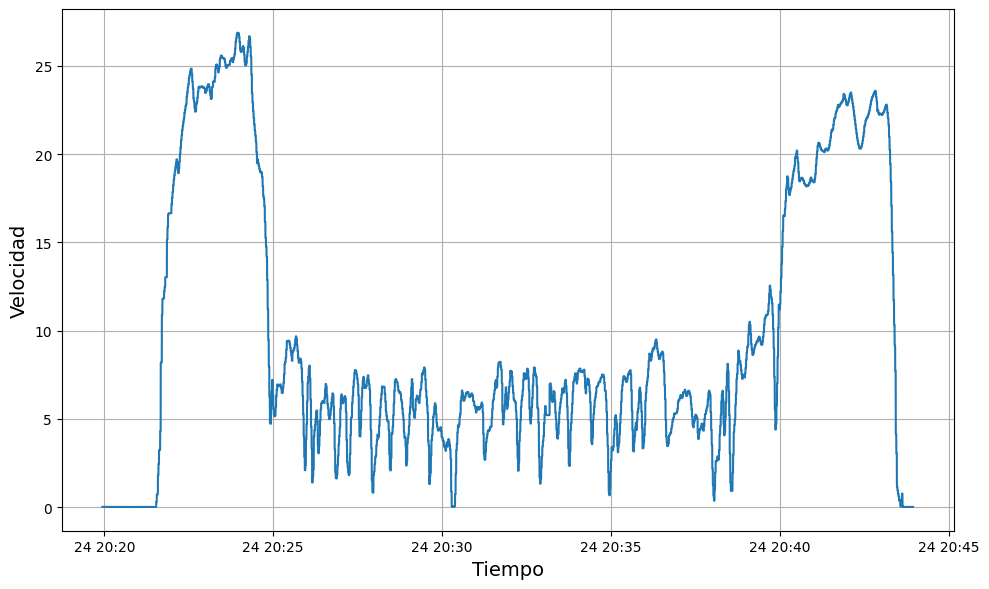

In [49]:
gps_mpu['timestamp'] = pd.to_datetime(gps_mpu['timestamp'],unit = 's') # Se graficaron los valores de speed del
plt.figure(figsize=(10,6))                                             # dataset gps que tiene menos datos con respecto  
plt.plot(gps_mpu['timestamp'],gps_mpu['speed'])                        # a los del dataset gps_mpu uy se puede ver que son iguales
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Velocidad', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

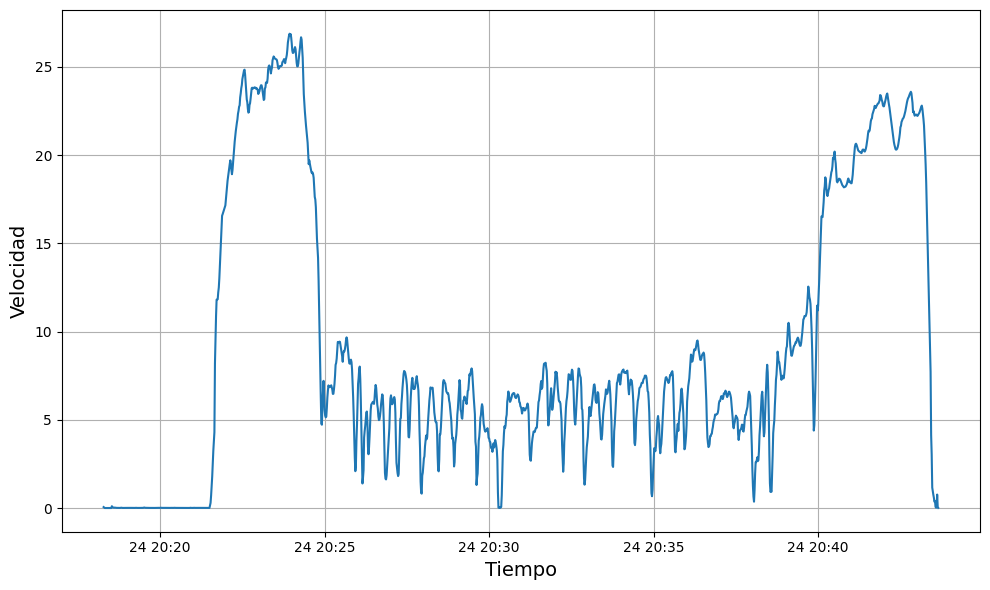

In [50]:
gps['timestamp'] = pd.to_datetime(gps['timestamp'],unit = 's')
plt.figure(figsize=(10,6))
plt.plot(gps['timestamp'],gps['speed_meters_per_second'])
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Velocidad', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
df_lbls = pd.read_csv('PVS 1/dataset_labels.csv')


In [52]:
df_lbls

,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,0,0,1,0,0,1,0,0
3,1,0,0,0,1,1,0,0,1,0,0,1,0,0
4,1,0,0,0,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,1,0,0,0,1,1,0,0,1,0,0,1,0,0
144032,1,0,0,0,1,1,0,0,1,0,0,1,0,0
144033,1,0,0,0,1,1,0,0,1,0,0,1,0,0
144034,1,0,0,0,1,1,0,0,1,0,0,1,0,0


In [53]:
df_PV1 = pd.concat([gps_mpu,df_lbls],axis = 1)

In [54]:
df_PV1

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,-0.133896,...,1,1,0,0,1,0,0,1,0,0
1,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,-0.027084,...,1,1,0,0,1,0,0,1,0,0
2,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,0.125504,...,1,1,0,0,1,0,0,1,0,0
3,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,-0.088120,...,1,1,0,0,1,0,0,1,0,0
4,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,-0.179672,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-0.527921,-0.322918,9.583271,-0.331976,-0.185200,9.528076,-0.704237,-0.054839,9.753122,-0.332260,...,1,1,0,0,1,0,0,1,0,0
144032,-0.663194,-0.575506,9.433633,-0.458869,-0.413847,10.223591,-0.748530,-0.212856,9.526870,-0.240707,...,1,1,0,0,1,0,0,1,0,0
144033,-0.375890,-0.245106,9.957964,-0.104527,-0.047534,9.687290,-0.719800,-0.150607,9.933885,0.064468,...,1,1,0,0,1,0,0,1,0,0
144034,-0.385466,-0.091877,9.840648,-0.530695,-0.452154,8.940299,-0.705434,-0.378056,10.003317,-0.423813,...,1,1,0,0,1,0,0,1,0,0


In [55]:
sttngs_PV1_right = pd.read_csv('PVS 1/dataset_settings_right.csv')

In [56]:
sttngs_PV1_right

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.847054,...,2.859215,1.175781,1.175781,1.140625,0.946237,1.08642,0.977778,9.960690,12.957712,-48.912897
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.288800,...,-0.425993,1.187500,1.187500,1.136719,3.035714,0.41769,3.617021,-37.747131,36.233684,37.070355
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-1.099749,...,3.165660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
sttngs_PV1_left = pd.read_csv('PVS 1/dataset_settings_left.csv')

In [58]:
sttngs_PV1_left

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-0.064468,...,4.433583,1.191406,1.195312,1.148438,1.037037,1.037037,0.933333,-4.733912,12.993733,-53.725000
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.509504,...,0.016409,0.500000,1.187500,1.187500,1.086420,1.333333,0.752137,-68.110939,32.272016,29.734768
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.987825,...,-0.445664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
sttngs_PV2_right = pd.read_csv('PVS 2/dataset_settings_right.csv')

In [60]:
sttngs_PV2_right

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.921631,...,2.774999,1.175781,1.175781,1.140625,1.049383,0.944444,1.011905,32.702798,6.346635,-46.005487
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.475069,...,-0.433993,1.187500,1.187500,1.136719,1.221532,0.500424,5.462963,-9.629770,34.987317,35.792067
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-0.970931,...,3.005977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
sttngs_PV2_left = pd.read_csv('PVS 2/dataset_settings_left.csv')

In [62]:
sttngs_PV2_left

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-0.335693,...,4.308862,1.191406,1.195312,1.148438,0.977011,1.049383,0.977011,17.774501,5.645553,-51.572556
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.625247,...,0.089345,1.132812,1.132812,1.144531,2.583333,1.968254,0.475096,2.745757,3.566907,14.930054
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.034328,...,-0.398863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
sttngs_PV3_right = pd.read_csv('PVS 3/dataset_settings_right.csv')

In [64]:
sttngs_PV3_right

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.971352,...,2.800282,1.175781,1.175781,1.140625,0.959596,1.130952,0.931373,32.702798,6.346635,-45.834463
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.604211,...,-0.396036,1.187500,1.195312,1.195312,0.461847,3.194444,1.916667,-9.714990,2.150687,37.995467
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-1.006708,...,3.032928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
sttngs_PV3_left = pd.read_csv('PVS 3/dataset_settings_left.csv')

In [66]:
sttngs_PV3_left

,placement,address_mpu,address_ak,gyroscope_full_scale,accelerometer_full_scale,magnetometer_full_scale,gyroscope_resolution,accelerometer_resolution,magnetometer_resolution,gyroscope_bias_x,...,accelerometer_bias_z,magnetometer_factory_sensitivity_x,magnetometer_factory_sensitivity_y,magnetometer_factory_sensitivity_z,magnetometer_soft_iron_distortion_x,magnetometer_soft_iron_distortion_y,magnetometer_soft_iron_distortion_z,magnetometer_hard_iron_distortion_x,magnetometer_hard_iron_distortion_y,magnetometer_hard_iron_distortion_z
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-0.441551,...,4.322611,1.191406,1.195312,1.148438,1.111111,0.919540,0.987654,17.685182,6.004001,-51.916947
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.537044,...,0.073928,1.132812,1.187500,1.144531,1.736111,1.157407,0.641026,2.038233,3.057349,27.543375
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.062121,...,-0.417788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
sttngs_PV2_left.columns = [col+'_left' for col in sttngs_PV2_left.columns]
sttngs_PV2_right.columns = [col+'_right' for col in sttngs_PV2_right.columns]
sttngs_PV3_right.columns = [col+'_right' for col in sttngs_PV3_right.columns]
sttngs_PV3_left.columns = [col+'_left' for col in sttngs_PV3_left.columns]
sttngs_PV1_right.columns = [col+'_right' for col in sttngs_PV1_right.columns]
sttngs_PV1_left.columns = [col+'_left' for col in sttngs_PV1_left.columns]

In [68]:
df_sttngs_PV2 = pd.concat([sttngs_PV2_left,sttngs_PV2_right],axis = 1)
df_sttngs_PV1 = pd.concat([sttngs_PV1_left,sttngs_PV1_right],axis = 1)
df_sttngs_PV3 = pd.concat([sttngs_PV3_left,sttngs_PV3_right],axis = 1)

In [69]:
df_sttngs_PV3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   placement_left                             3 non-null      object 
 1   address_mpu_left                           3 non-null      object 
 2   address_ak_left                            2 non-null      object 
 3   gyroscope_full_scale_left                  3 non-null      object 
 4   accelerometer_full_scale_left              3 non-null      object 
 5   magnetometer_full_scale_left               3 non-null      object 
 6   gyroscope_resolution_left                  3 non-null      float64
 7   accelerometer_resolution_left              3 non-null      float64
 8   magnetometer_resolution_left               3 non-null      float64
 9   gyroscope_bias_x_left                      3 non-null      float64
 10  gyroscope_bias_y_left         

In [70]:
df_sttngs_PV3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   placement_left                             3 non-null      object 
 1   address_mpu_left                           3 non-null      object 
 2   address_ak_left                            2 non-null      object 
 3   gyroscope_full_scale_left                  3 non-null      object 
 4   accelerometer_full_scale_left              3 non-null      object 
 5   magnetometer_full_scale_left               3 non-null      object 
 6   gyroscope_resolution_left                  3 non-null      float64
 7   accelerometer_resolution_left              3 non-null      float64
 8   magnetometer_resolution_left               3 non-null      float64
 9   gyroscope_bias_x_left                      3 non-null      float64
 10  gyroscope_bias_y_left         

In [71]:
pd.set_option('display.max_rows', None) #Podemos ver que no hay valores nulos
df_PV1.isnull().sum()

acc_x_dashboard_left             0
acc_y_dashboard_left             0
acc_z_dashboard_left             0
acc_x_above_suspension_left      0
acc_y_above_suspension_left      0
acc_z_above_suspension_left      0
acc_x_below_suspension_left      0
acc_y_below_suspension_left      0
acc_z_below_suspension_left      0
gyro_x_dashboard_left            0
gyro_y_dashboard_left            0
gyro_z_dashboard_left            0
gyro_x_above_suspension_left     0
gyro_y_above_suspension_left     0
gyro_z_above_suspension_left     0
gyro_x_below_suspension_left     0
gyro_y_below_suspension_left     0
gyro_z_below_suspension_left     0
mag_x_dashboard_left             0
mag_y_dashboard_left             0
mag_z_dashboard_left             0
mag_x_above_suspension_left      0
mag_y_above_suspension_left      0
mag_z_above_suspension_left      0
temp_dashboard_left              0
temp_above_suspension_left       0
temp_below_suspension_left       0
acc_x_dashboard_right            0
acc_y_dashboard_righ

In [72]:
gps_PV2 = pd.read_csv('PVS 2/dataset_gps.csv')
gps_mpu_left_PV2 = pd.read_csv('PVS 2/dataset_gps_mpu_left.csv')
gps_mpu_right_PV2 = pd.read_csv('PVS 2/dataset_gps_mpu_right.csv')
gps_mpu_left_PV2.columns = [col+'_left' for col in gps_mpu_left_PV2.columns]
gps_mpu_right_PV2.columns = [col+'_right' for col in gps_mpu_right_PV2.columns]

In [73]:
pd.reset_option('display.max_rows')
gps_mpu_left_PV2

,timestamp_left,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,...,mag_x_above_suspension_left,mag_y_above_suspension_left,mag_z_above_suspension_left,temp_dashboard_left,temp_above_suspension_left,temp_below_suspension_left,timestamp_gps_left,latitude_left,longitude_left,speed_left
0,1.577221e+09,-0.029431,-0.019621,9.781015,0.024584,-0.025781,9.798708,0.026450,-0.026963,9.846382,...,-6.215633,4.163336e-16,-7.011675,32.166023,41.894360,35.640429,1.577221e+09,-27.717712,-51.099027,0.010822
1,1.577221e+09,-0.039008,0.009110,9.819322,-0.004146,-0.046132,9.798708,0.015676,0.012541,9.803287,...,-7.093206,4.346073e+00,-7.093206,32.453560,41.750592,35.424776,1.577221e+09,-27.717712,-51.099027,0.010822
2,1.577221e+09,0.010073,0.005518,9.777423,-0.031679,0.001752,9.822650,0.034830,-0.019781,9.776950,...,-7.093206,-1.002940e+00,-7.093206,32.405637,41.966244,35.951927,1.577221e+09,-27.717712,-51.099027,0.010822
3,1.577221e+09,0.020847,0.028263,9.785803,-0.037665,0.023300,9.793920,0.001311,0.012541,9.786527,...,-7.093206,-1.671566e+00,-7.093206,32.453560,41.942283,35.520622,1.577221e+09,-27.717712,-51.099027,0.010822
4,1.577221e+09,-0.003095,-0.017227,9.800168,0.048526,-0.003037,9.803497,0.025253,0.019724,9.767374,...,-6.215633,-1.671566e+00,5.951770,32.309791,41.990206,35.664390,1.577221e+09,-27.717712,-51.099027,0.010822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124679,1.577222e+09,0.427861,-0.261435,9.958185,0.207741,-0.319071,9.609566,0.275447,-0.418415,9.849974,...,-6.435026,5.014699e-01,6.074067,32.070177,34.777818,31.231527,1.577222e+09,-27.717741,-51.099118,0.023570
124680,1.577222e+09,0.466169,-0.316502,9.867206,0.113170,-0.508213,9.030170,0.223972,-0.614740,9.982852,...,-7.093206,3.677446e+00,6.114832,32.094138,34.562165,31.399257,1.577222e+09,-27.717741,-51.099118,0.023570
124681,1.577222e+09,0.332093,-0.555922,9.646939,0.309494,-0.309494,9.868140,0.238337,-0.099986,9.688365,...,-7.093206,3.677446e+00,6.604019,32.261868,34.945548,31.255489,1.577222e+09,-27.717741,-51.099118,0.023570
124682,1.577222e+09,0.339276,-0.570287,9.824110,0.548915,-0.369349,9.753218,0.247914,-0.710508,9.365148,...,-7.093206,3.677446e+00,6.114832,32.070177,34.897625,31.303412,1.577222e+09,-27.717741,-51.099118,0.023570


In [74]:
matching_columns,gps_mpu_PV2 = get_matching_columns(gps_mpu_left_PV2,gps_mpu_right_PV2,'timestamp_left','timestamp_right')

In [75]:
matching_columns

['timestamp', 'timestamp_gps', 'latitude', 'longitude', 'speed']

In [76]:
gps_mpu_PV2['timestamp'] = gps_mpu_PV2['timestamp_left']
gps_mpu_PV2['timestamp_gps'] = gps_mpu_PV2['timestamp_gps_left']
gps_mpu_PV2['latitude'] = gps_mpu_PV2['latitude_left']
gps_mpu_PV2['longitude'] = gps_mpu_PV2['longitude_left']
gps_mpu_PV2['speed'] = gps_mpu_PV2['speed_left']
gps_mpu_PV2.drop(columns=['timestamp_match','timestamp_right','timestamp_left','timestamp_gps_left','timestamp_gps_right','latitude_left','latitude_right','longitude_left','longitude_right','speed_left','speed_right'],inplace = True)

In [77]:
gps_mpu_PV2

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp,timestamp_gps,latitude,longitude,speed
0,-0.029431,-0.019621,9.781015,0.024584,-0.025781,9.798708,0.026450,-0.026963,9.846382,-0.122070,...,-16.617479,-7.448790,32.094138,46.686645,38.108455,1.577221e+09,1.577221e+09,-27.717712,-51.099027,0.010822
1,-0.039008,0.009110,9.819322,-0.004146,-0.046132,9.798708,0.015676,0.012541,9.803287,-0.030518,...,-16.795682,-5.586593,31.974331,46.590799,38.156378,1.577221e+09,1.577221e+09,-27.717712,-51.099027,0.010822
2,0.010073,0.005518,9.777423,-0.031679,0.001752,9.822650,0.034830,-0.019781,9.776950,-0.122070,...,-17.152089,-9.310988,31.926408,46.351185,38.395992,1.577221e+09,1.577221e+09,-27.717712,-51.099027,0.010822
3,0.020847,0.028263,9.785803,-0.037665,0.023300,9.793920,0.001311,0.012541,9.786527,0.061035,...,-16.617479,-13.035383,32.118100,46.494953,38.108455,1.577221e+09,1.577221e+09,-27.717712,-51.099027,0.010822
4,-0.003095,-0.017227,9.800168,0.048526,-0.003037,9.803497,0.025253,0.019724,9.767374,-0.091553,...,-16.617479,-1.862198,32.118100,46.494953,37.916764,1.577221e+09,1.577221e+09,-27.717712,-51.099027,0.010822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124679,0.427861,-0.261435,9.958185,0.207741,-0.319071,9.609566,0.275447,-0.418415,9.849974,0.030518,...,-0.044551,-195.530738,31.207566,39.450295,32.261868,1.577222e+09,1.577222e+09,-27.717741,-51.099118,0.023570
124680,0.466169,-0.316502,9.867206,0.113170,-0.508213,9.030170,0.223972,-0.614740,9.982852,-0.122070,...,-0.400958,-135.940418,31.303412,39.737832,32.261868,1.577222e+09,1.577222e+09,-27.717741,-51.099118,0.023570
124681,0.332093,-0.555922,9.646939,0.309494,-0.309494,9.868140,0.238337,-0.099986,9.688365,-0.183105,...,-2.361197,-134.078220,31.279450,39.498218,32.309791,1.577222e+09,1.577222e+09,-27.717741,-51.099118,0.023570
124682,0.339276,-0.570287,9.824110,0.548915,-0.369349,9.753218,0.247914,-0.710508,9.365148,-0.122070,...,-1.202874,-164.804479,31.255489,39.689909,32.189984,1.577222e+09,1.577222e+09,-27.717741,-51.099118,0.023570


In [78]:
gps_mpu_PV2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124684 entries, 0 to 124683
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           124684 non-null  float64
 1   acc_y_dashboard_left           124684 non-null  float64
 2   acc_z_dashboard_left           124684 non-null  float64
 3   acc_x_above_suspension_left    124684 non-null  float64
 4   acc_y_above_suspension_left    124684 non-null  float64
 5   acc_z_above_suspension_left    124684 non-null  float64
 6   acc_x_below_suspension_left    124684 non-null  float64
 7   acc_y_below_suspension_left    124684 non-null  float64
 8   acc_z_below_suspension_left    124684 non-null  float64
 9   gyro_x_dashboard_left          124684 non-null  float64
 10  gyro_y_dashboard_left          124684 non-null  float64
 11  gyro_z_dashboard_left          124684 non-null  float64
 12  gyro_x_above_suspension_left  

In [79]:
df_lbls_PV2 = pd.read_csv('PVS 2/dataset_labels.csv')

In [80]:
df_lbls_PV2

,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,0,0,1,0,0,1,0,0
3,1,0,0,0,1,1,0,0,1,0,0,1,0,0
4,1,0,0,0,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124679,1,0,0,0,1,1,0,0,1,0,0,1,0,0
124680,1,0,0,0,1,1,0,0,1,0,0,1,0,0
124681,1,0,0,0,1,1,0,0,1,0,0,1,0,0
124682,1,0,0,0,1,1,0,0,1,0,0,1,0,0


In [81]:
df_PV2 = pd.concat([gps_mpu_PV2,df_lbls_PV2],axis = 1)

In [82]:
df_PV2

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,-0.029431,-0.019621,9.781015,0.024584,-0.025781,9.798708,0.026450,-0.026963,9.846382,-0.122070,...,1,1,0,0,1,0,0,1,0,0
1,-0.039008,0.009110,9.819322,-0.004146,-0.046132,9.798708,0.015676,0.012541,9.803287,-0.030518,...,1,1,0,0,1,0,0,1,0,0
2,0.010073,0.005518,9.777423,-0.031679,0.001752,9.822650,0.034830,-0.019781,9.776950,-0.122070,...,1,1,0,0,1,0,0,1,0,0
3,0.020847,0.028263,9.785803,-0.037665,0.023300,9.793920,0.001311,0.012541,9.786527,0.061035,...,1,1,0,0,1,0,0,1,0,0
4,-0.003095,-0.017227,9.800168,0.048526,-0.003037,9.803497,0.025253,0.019724,9.767374,-0.091553,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124679,0.427861,-0.261435,9.958185,0.207741,-0.319071,9.609566,0.275447,-0.418415,9.849974,0.030518,...,1,1,0,0,1,0,0,1,0,0
124680,0.466169,-0.316502,9.867206,0.113170,-0.508213,9.030170,0.223972,-0.614740,9.982852,-0.122070,...,1,1,0,0,1,0,0,1,0,0
124681,0.332093,-0.555922,9.646939,0.309494,-0.309494,9.868140,0.238337,-0.099986,9.688365,-0.183105,...,1,1,0,0,1,0,0,1,0,0
124682,0.339276,-0.570287,9.824110,0.548915,-0.369349,9.753218,0.247914,-0.710508,9.365148,-0.122070,...,1,1,0,0,1,0,0,1,0,0


In [83]:
gps_PV3 = pd.read_csv('PVS 3/dataset_gps.csv')
gps_mpu_left_PV3 = pd.read_csv('PVS 3/dataset_gps_mpu_left.csv')
gps_mpu_right_PV3 = pd.read_csv('PVS 3/dataset_gps_mpu_right.csv')
gps_mpu_left_PV3.columns = [col+'_left' for col in gps_mpu_left_PV3.columns]
gps_mpu_right_PV3.columns = [col+'_right' for col in gps_mpu_right_PV3.columns]

In [84]:
gps_mpu_left_PV3

,timestamp_left,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,...,mag_x_above_suspension_left,mag_y_above_suspension_left,mag_z_above_suspension_left,temp_dashboard_left,temp_above_suspension_left,temp_below_suspension_left,timestamp_gps_left,latitude_left,longitude_left,speed_left
0,1.577223e+09,0.017119,-0.009158,9.781631,-0.012380,-0.041110,9.783000,0.019439,-0.013738,9.738415,...,-3.538598,-3.538598,-3.465198,32.573367,43.427891,35.281008,1.577223e+09,-27.717713,-51.099037,0.008459
1,1.577223e+09,-0.016400,0.012390,9.781631,0.025927,-0.038716,9.814125,0.001482,-0.002964,9.821015,...,-1.179533,-3.538598,-2.475142,32.645251,43.451853,35.424776,1.577223e+09,-27.717713,-51.099037,0.008459
2,1.577223e+09,-0.018794,-0.018735,9.769660,0.033110,-0.045899,9.761452,0.012256,-0.013738,9.781511,...,-3.538598,-3.538598,-3.135179,32.645251,43.523737,35.520622,1.577223e+09,-27.717713,-51.099037,0.008459
3,1.577223e+09,-0.014006,0.000419,9.815149,-0.007591,-0.024351,9.823701,0.019439,-0.013738,9.757569,...,-1.769299,-3.538598,-3.135179,32.501483,43.523737,35.281008,1.577223e+09,-27.717713,-51.099037,0.008459
4,1.577223e+09,-0.008021,0.011193,9.803178,0.033110,-0.021957,9.751875,-0.004503,-0.013738,9.786299,...,-2.948832,-3.538598,-3.355192,32.453560,43.667505,35.233085,1.577223e+09,-27.717713,-51.099037,0.008459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105811,1.577224e+09,-0.016400,-0.540671,9.855851,-0.000409,-0.553469,9.708780,-0.121819,-0.516521,9.800664,...,-121.491874,0.170829,5.225299,31.063797,32.166023,28.763501,1.577224e+09,-27.717802,-51.099076,0.018415
105812,1.577224e+09,-0.042736,-0.552642,9.810361,0.023533,-0.572623,9.756664,-0.090695,-0.494973,9.762357,...,-123.850939,0.170829,5.225299,31.015874,32.166023,28.763501,1.577224e+09,-27.717802,-51.099076,0.018415
105813,1.577224e+09,-0.011612,-0.538276,9.836697,0.061840,-0.517556,9.677655,-0.100271,-0.554828,9.812636,...,-123.850939,0.170829,5.225299,31.015874,32.118100,28.907269,1.577224e+09,-27.717802,-51.099076,0.018415
105814,1.577224e+09,-0.022386,-0.565810,9.846274,0.001985,-0.565440,9.683641,-0.101469,-0.514126,9.805453,...,-124.588147,-0.756528,3.960226,31.039836,32.118100,28.931231,1.577224e+09,-27.717802,-51.099076,0.018415


In [85]:
matching_columns,gps_mpu_PV3 = get_matching_columns(gps_mpu_left_PV3,gps_mpu_right_PV3,'timestamp_left','timestamp_right')

In [86]:
matching_columns

['timestamp', 'timestamp_gps', 'latitude', 'longitude', 'speed']

In [87]:
gps_mpu_PV3['timestamp'] = gps_mpu_PV3['timestamp_left']
gps_mpu_PV3['timestamp_gps'] = gps_mpu_PV3['timestamp_gps_left']
gps_mpu_PV3['latitude'] = gps_mpu_PV3['latitude_left']
gps_mpu_PV3['longitude'] = gps_mpu_PV3['longitude_left']
gps_mpu_PV3['speed'] = gps_mpu_PV3['speed_left']
gps_mpu_PV3.drop(columns=['timestamp_match','timestamp_right','timestamp_left','timestamp_gps_left','timestamp_gps_right','latitude_left','latitude_right','longitude_left','longitude_right','speed_left','speed_right'],inplace = True)

In [88]:
gps_mpu_PV3

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp,timestamp_gps,latitude,longitude,speed
0,0.017119,-0.009158,9.781631,-0.012380,-0.041110,9.783000,0.019439,-0.013738,9.738415,0.044823,...,-2.290083,-1.030537,31.255489,47.117950,37.916764,1.577223e+09,1.577223e+09,-27.717713,-51.099037,0.008459
1,-0.016400,0.012390,9.781631,0.025927,-0.038716,9.814125,0.001482,-0.002964,9.821015,0.227928,...,2.862604,-6.526737,31.447180,46.926259,37.916764,1.577223e+09,1.577223e+09,-27.717713,-51.099037,0.008459
2,-0.018794,-0.018735,9.769660,0.033110,-0.045899,9.761452,0.012256,-0.013738,9.781511,0.044823,...,2.862604,-6.526737,31.543026,47.022104,37.964687,1.577223e+09,1.577223e+09,-27.717713,-51.099037,0.008459
3,-0.014006,0.000419,9.815149,-0.007591,-0.024351,9.823701,0.019439,-0.013738,9.757569,-0.046730,...,2.290083,-6.870250,31.255489,47.022104,37.916764,1.577223e+09,1.577223e+09,-27.717713,-51.099037,0.008459
4,-0.008021,0.011193,9.803178,0.033110,-0.021957,9.751875,-0.004503,-0.013738,9.786299,0.060081,...,-2.290083,-6.870250,31.255489,46.974182,37.772995,1.577223e+09,1.577223e+09,-27.717713,-51.099037,0.008459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105811,-0.016400,-0.540671,9.855851,-0.000409,-0.553469,9.708780,-0.121819,-0.516521,9.800664,-0.107765,...,144.847761,4.465662,29.817803,37.030191,29.697996,1.577224e+09,1.577224e+09,-27.717802,-51.099076,0.018415
105812,-0.042736,-0.552642,9.810361,0.023533,-0.572623,9.756664,-0.090695,-0.494973,9.762357,-0.046730,...,148.855407,5.496200,29.817803,37.006230,29.961572,1.577224e+09,1.577224e+09,-27.717802,-51.099076,0.018415
105813,-0.011612,-0.538276,9.836697,0.061840,-0.517556,9.677655,-0.100271,-0.554828,9.812636,0.105858,...,151.145490,6.870250,30.057418,37.054153,29.961572,1.577224e+09,1.577224e+09,-27.717802,-51.099076,0.018415
105814,-0.022386,-0.565810,9.846274,0.001985,-0.565440,9.683641,-0.101469,-0.514126,9.805453,0.121117,...,151.145490,7.557274,29.913649,36.814539,29.674035,1.577224e+09,1.577224e+09,-27.717802,-51.099076,0.018415


In [89]:
gps_mpu_PV3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105816 entries, 0 to 105815
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           105816 non-null  float64
 1   acc_y_dashboard_left           105816 non-null  float64
 2   acc_z_dashboard_left           105816 non-null  float64
 3   acc_x_above_suspension_left    105816 non-null  float64
 4   acc_y_above_suspension_left    105816 non-null  float64
 5   acc_z_above_suspension_left    105816 non-null  float64
 6   acc_x_below_suspension_left    105816 non-null  float64
 7   acc_y_below_suspension_left    105816 non-null  float64
 8   acc_z_below_suspension_left    105816 non-null  float64
 9   gyro_x_dashboard_left          105816 non-null  float64
 10  gyro_y_dashboard_left          105816 non-null  float64
 11  gyro_z_dashboard_left          105816 non-null  float64
 12  gyro_x_above_suspension_left  

In [90]:
df_lbls_PV3 = pd.read_csv('PVS 3/dataset_labels.csv')

In [91]:
df_lbls_PV3

,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,0,0,1,0,0,1,0,0
3,1,0,0,0,1,1,0,0,1,0,0,1,0,0
4,1,0,0,0,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105811,1,0,0,0,1,1,0,0,1,0,0,1,0,0
105812,1,0,0,0,1,1,0,0,1,0,0,1,0,0
105813,1,0,0,0,1,1,0,0,1,0,0,1,0,0
105814,1,0,0,0,1,1,0,0,1,0,0,1,0,0


In [92]:
df_PV3 = pd.concat([gps_mpu_PV3,df_lbls_PV3],axis = 1)

In [93]:
df_PV3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105816 entries, 0 to 105815
Data columns (total 73 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   acc_x_dashboard_left           105816 non-null  float64
 1   acc_y_dashboard_left           105816 non-null  float64
 2   acc_z_dashboard_left           105816 non-null  float64
 3   acc_x_above_suspension_left    105816 non-null  float64
 4   acc_y_above_suspension_left    105816 non-null  float64
 5   acc_z_above_suspension_left    105816 non-null  float64
 6   acc_x_below_suspension_left    105816 non-null  float64
 7   acc_y_below_suspension_left    105816 non-null  float64
 8   acc_z_below_suspension_left    105816 non-null  float64
 9   gyro_x_dashboard_left          105816 non-null  float64
 10  gyro_y_dashboard_left          105816 non-null  float64
 11  gyro_z_dashboard_left          105816 non-null  float64
 12  gyro_x_above_suspension_left  

In [94]:
df_sttngs_PV1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   placement_left                             3 non-null      object 
 1   address_mpu_left                           3 non-null      object 
 2   address_ak_left                            2 non-null      object 
 3   gyroscope_full_scale_left                  3 non-null      object 
 4   accelerometer_full_scale_left              3 non-null      object 
 5   magnetometer_full_scale_left               3 non-null      object 
 6   gyroscope_resolution_left                  3 non-null      float64
 7   accelerometer_resolution_left              3 non-null      float64
 8   magnetometer_resolution_left               3 non-null      float64
 9   gyroscope_bias_x_left                      3 non-null      float64
 10  gyroscope_bias_y_left         

In [95]:
df_1 =  Correc_Datos(df_PV1.copy(),df_sttngs_PV1)

In [96]:
df_2 =  Correc_Datos(df_PV2.copy(),df_sttngs_PV2)

In [97]:
df_3 =  Correc_Datos(df_PV3.copy(),df_sttngs_PV3)

In [98]:
df_1

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,-0.379481,0.374693,14.227543,1.219846,-0.205901,9.798270,0.687136,-0.196325,9.348160,-0.198364,...,1,1,0,0,1,0,0,1,0,0
1,-0.351948,0.383072,14.204798,1.273715,-0.189142,9.715670,0.687136,-0.174777,9.397242,-0.091553,...,1,1,0,0,1,0,0,1,0,0
2,-0.335188,0.387861,14.166491,1.175553,-0.196325,9.823409,0.665588,-0.141258,9.442731,0.061035,...,1,1,0,0,1,0,0,1,0,0
3,-0.373495,0.371101,14.183251,1.206678,-0.148441,9.756372,0.667982,-0.196325,9.425972,-0.152588,...,1,1,0,0,1,0,0,1,0,0
4,-0.354342,0.366313,14.302961,1.236605,-0.175974,9.779117,0.667982,-0.168791,9.415198,-0.244141,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-1.272518,-0.116119,14.016854,0.560243,-0.563834,9.544485,-0.041899,-0.423774,9.307459,-0.396729,...,1,1,0,0,1,0,0,1,0,0
144032,-1.407791,-0.368707,13.867216,0.433351,-0.792481,10.240001,-0.086191,-0.581791,9.081207,-0.305176,...,1,1,0,0,1,0,0,1,0,0
144033,-1.120486,-0.038307,14.391546,0.787692,-0.426168,9.703699,-0.057461,-0.519542,9.488221,0.000000,...,1,1,0,0,1,0,0,1,0,0
144034,-1.130063,0.114922,14.274230,0.361524,-0.830788,8.956708,-0.043096,-0.746991,9.557653,-0.488281,...,1,1,0,0,1,0,0,1,0,0


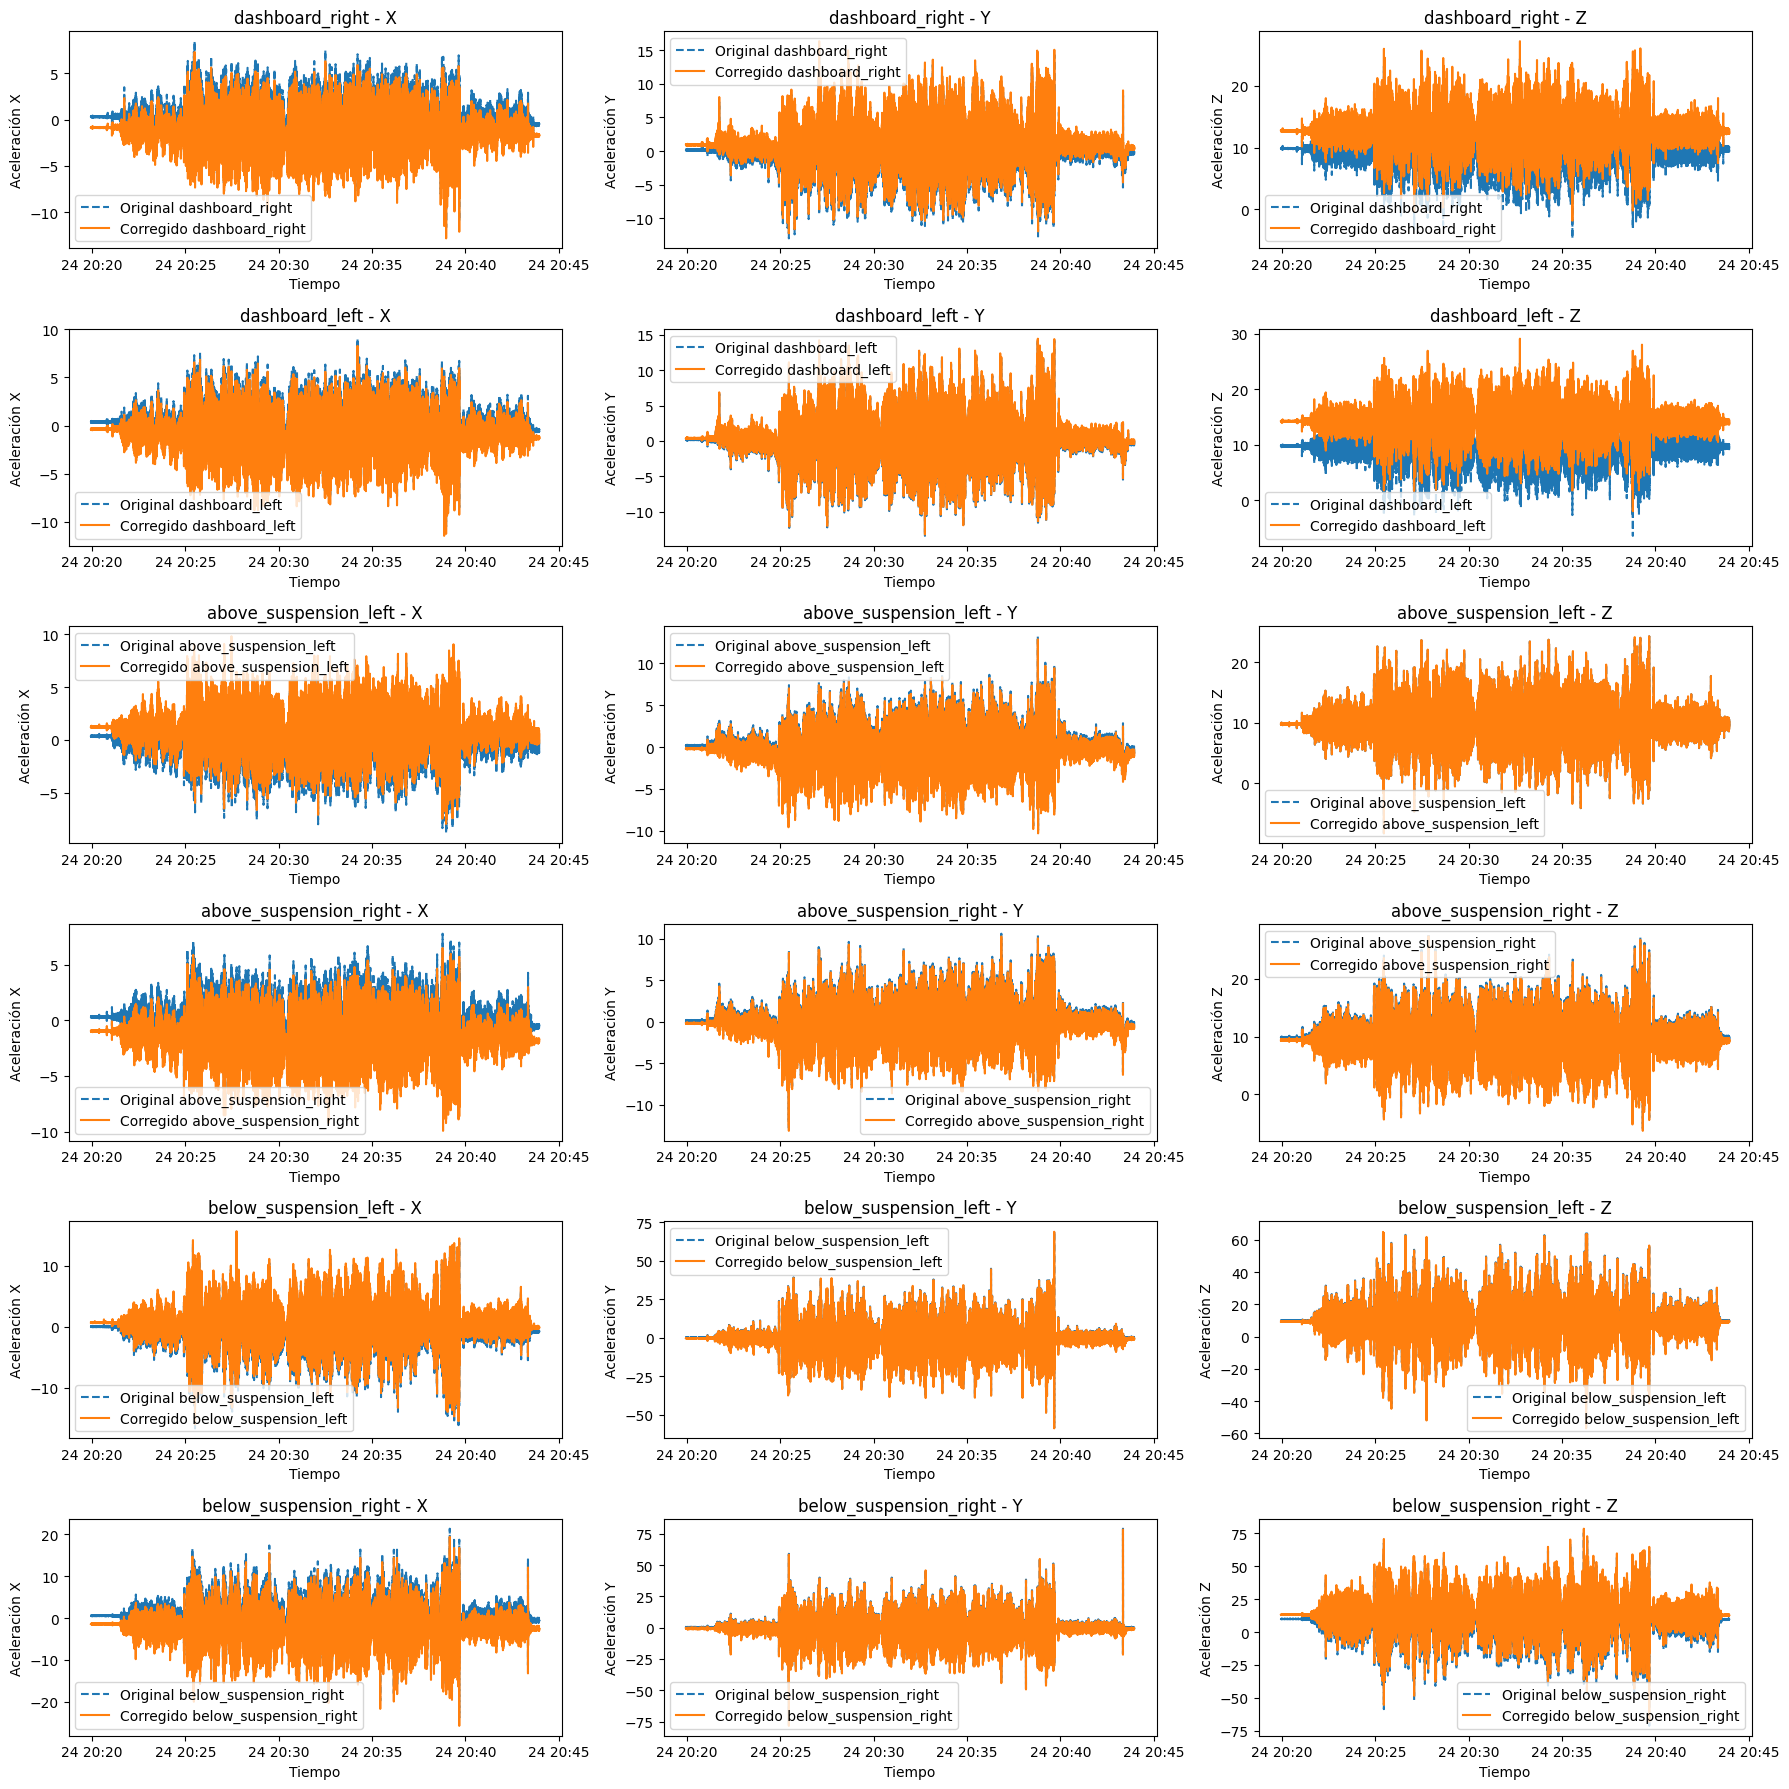

In [99]:

Ubicaciones_sensor = ['dashboard_right', 'dashboard_left', 'above_suspension_left', 'above_suspension_right', 'below_suspension_left', 'below_suspension_right']
ejes = ['x', 'y', 'z']

plt.figure(figsize=(18, 18))  # Graficamos las aceleraciopnes para verificar que se hizo bien la correcion

#
for i, sensor in enumerate(Ubicaciones_sensor):
    for j, axis in enumerate(ejes):
        plt.subplot(6, 3, i*3 + j + 1)
        col_original = f'acc_{axis}_{sensor}'
        col_corregido = f'acc_{axis}_{sensor}'
        
        plt.plot(df_PV1['timestamp'], df_PV1[col_original], label=f'Original {sensor}', linestyle='--')
        plt.plot(df_1['timestamp'], df_1[col_corregido], label=f'Corregido {sensor}')
        
        plt.xlabel('Tiempo')
        plt.ylabel(f'Aceleración {axis.upper()}')
        plt.title(f'{sensor} - {axis.upper()}')
        plt.legend()

plt.tight_layout()
plt.show()




In [100]:
df_sttngs_PV1['accelerometer_bias_x_right'] # Podemos ver que que coinciden las magnitudes y signo de los bias con las graficas

0   -1.164839
1   -1.284402
2   -1.942398
Name: accelerometer_bias_x_right, dtype: float64

In [101]:
df_sttngs_PV1['accelerometer_bias_z_left'] 

0    4.433583
1    0.016409
2   -0.445664
Name: accelerometer_bias_z_left, dtype: float64

In [102]:
df_sttngs_PV1

,placement_left,address_mpu_left,address_ak_left,gyroscope_full_scale_left,accelerometer_full_scale_left,magnetometer_full_scale_left,gyroscope_resolution_left,accelerometer_resolution_left,magnetometer_resolution_left,gyroscope_bias_x_left,...,accelerometer_bias_z_right,magnetometer_factory_sensitivity_x_right,magnetometer_factory_sensitivity_y_right,magnetometer_factory_sensitivity_z_right,magnetometer_soft_iron_distortion_x_right,magnetometer_soft_iron_distortion_y_right,magnetometer_soft_iron_distortion_z_right,magnetometer_hard_iron_distortion_x_right,magnetometer_hard_iron_distortion_y_right,magnetometer_hard_iron_distortion_z_right
0,dashboard,0x69,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,-0.064468,...,2.859215,1.175781,1.175781,1.140625,0.946237,1.08642,0.977778,9.960690,12.957712,-48.912897
1,above_suspension,0x68,0xc,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,1.509504,...,-0.425993,1.187500,1.187500,1.136719,3.035714,0.41769,3.617021,-37.747131,36.233684,37.070355
2,below_suspension,0x68,NaN,GFS_1000,AFS_8G,AK8963_BIT_16,0.030518,0.000244,0.149939,0.987825,...,3.165660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df_1

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,-0.379481,0.374693,14.227543,1.219846,-0.205901,9.798270,0.687136,-0.196325,9.348160,-0.198364,...,1,1,0,0,1,0,0,1,0,0
1,-0.351948,0.383072,14.204798,1.273715,-0.189142,9.715670,0.687136,-0.174777,9.397242,-0.091553,...,1,1,0,0,1,0,0,1,0,0
2,-0.335188,0.387861,14.166491,1.175553,-0.196325,9.823409,0.665588,-0.141258,9.442731,0.061035,...,1,1,0,0,1,0,0,1,0,0
3,-0.373495,0.371101,14.183251,1.206678,-0.148441,9.756372,0.667982,-0.196325,9.425972,-0.152588,...,1,1,0,0,1,0,0,1,0,0
4,-0.354342,0.366313,14.302961,1.236605,-0.175974,9.779117,0.667982,-0.168791,9.415198,-0.244141,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144031,-1.272518,-0.116119,14.016854,0.560243,-0.563834,9.544485,-0.041899,-0.423774,9.307459,-0.396729,...,1,1,0,0,1,0,0,1,0,0
144032,-1.407791,-0.368707,13.867216,0.433351,-0.792481,10.240001,-0.086191,-0.581791,9.081207,-0.305176,...,1,1,0,0,1,0,0,1,0,0
144033,-1.120486,-0.038307,14.391546,0.787692,-0.426168,9.703699,-0.057461,-0.519542,9.488221,0.000000,...,1,1,0,0,1,0,0,1,0,0
144034,-1.130063,0.114922,14.274230,0.361524,-0.830788,8.956708,-0.043096,-0.746991,9.557653,-0.488281,...,1,1,0,0,1,0,0,1,0,0


In [104]:
df_1['Speed_Target'] = df_1['speed'].shift(-1) # Se crea una Velocidad como target y otras tres como caracterisitcas que sirvan para el modelo
df_2['Speed_Target'] = df_2['speed'].shift(-1)
df_3['Speed_Target'] = df_3['speed'].shift(-1)
df_1['speed_t-1'] = df_1['speed'].shift(1)
df_2['speed_t-1'] = df_2['speed'].shift(1)
df_3['speed_t-1'] = df_3['speed'].shift(1)
df_1['speed_t-2'] = df_1['speed'].shift(2)
df_2['speed_t-2'] = df_2['speed'].shift(2)
df_3['speed_t-2'] = df_3['speed'].shift(2)
df_1['speed_t-3'] = df_1['speed'].shift(3)
df_2['speed_t-3'] = df_2['speed'].shift(3)
df_3['speed_t-3'] = df_3['speed'].shift(3)

In [105]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 77 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   acc_x_dashboard_left           144036 non-null  float64       
 1   acc_y_dashboard_left           144036 non-null  float64       
 2   acc_z_dashboard_left           144036 non-null  float64       
 3   acc_x_above_suspension_left    144036 non-null  float64       
 4   acc_y_above_suspension_left    144036 non-null  float64       
 5   acc_z_above_suspension_left    144036 non-null  float64       
 6   acc_x_below_suspension_left    144036 non-null  float64       
 7   acc_y_below_suspension_left    144036 non-null  float64       
 8   acc_z_below_suspension_left    144036 non-null  float64       
 9   gyro_x_dashboard_left          144036 non-null  float64       
 10  gyro_y_dashboard_left          144036 non-null  float64       
 11  

In [106]:
df_1 = Calcular_Acel(df_1) # Se usan funciones para Calcular la aceleracion en magnitud por eje y en promedio
df_2 = Calcular_Acel(df_2)  
df_3 = Calcular_Acel(df_3)
df_1 = Calcular_Vel_Ang(df_1)
df_2 = Calcular_Vel_Ang(df_2)  
df_3 = Calcular_Vel_Ang(df_3)

In [107]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144036 entries, 0 to 144035
Data columns (total 85 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   acc_x_dashboard_left           144036 non-null  float64       
 1   acc_y_dashboard_left           144036 non-null  float64       
 2   acc_z_dashboard_left           144036 non-null  float64       
 3   acc_x_above_suspension_left    144036 non-null  float64       
 4   acc_y_above_suspension_left    144036 non-null  float64       
 5   acc_z_above_suspension_left    144036 non-null  float64       
 6   acc_x_below_suspension_left    144036 non-null  float64       
 7   acc_y_below_suspension_left    144036 non-null  float64       
 8   acc_z_below_suspension_left    144036 non-null  float64       
 9   gyro_x_dashboard_left          144036 non-null  float64       
 10  gyro_y_dashboard_left          144036 non-null  float64       
 11  

In [108]:
df_1 = df_1.drop(['temp_below_suspension_right','temp_dashboard_right','temp_below_suspension_left','temp_dashboard_left',
 'temp_above_suspension_right','temp_above_suspension_left','mag_x_dashboard_left','mag_y_dashboard_left','mag_z_dashboard_left',
 'mag_x_above_suspension_left','mag_y_above_suspension_left','mag_z_above_suspension_left','mag_x_dashboard_right','mag_y_dashboard_right',
'mag_z_dashboard_right','mag_x_above_suspension_right','mag_y_above_suspension_right','mag_z_above_suspension_right'],axis = 1)
df_2 = df_2.drop(['temp_below_suspension_right','temp_dashboard_right','temp_below_suspension_left','temp_dashboard_left',
 'temp_above_suspension_right','temp_above_suspension_left','mag_x_dashboard_left','mag_y_dashboard_left','mag_z_dashboard_left',
 'mag_x_above_suspension_left','mag_y_above_suspension_left','mag_z_above_suspension_left','mag_x_dashboard_right','mag_y_dashboard_right',
'mag_z_dashboard_right','mag_x_above_suspension_right','mag_y_above_suspension_right','mag_z_above_suspension_right'],axis = 1)
df_3 = df_3.drop(['temp_below_suspension_right','temp_dashboard_right','temp_below_suspension_left','temp_dashboard_left',
 'temp_above_suspension_right','temp_above_suspension_left','mag_x_dashboard_left','mag_y_dashboard_left','mag_z_dashboard_left',
 'mag_x_above_suspension_left','mag_y_above_suspension_left','mag_z_above_suspension_left','mag_x_dashboard_right','mag_y_dashboard_right',
'mag_z_dashboard_right','mag_x_above_suspension_right','mag_y_above_suspension_right','mag_z_above_suspension_right'],axis = 1)

In [109]:
df_1 = df_1.drop(['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
              'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
              'acc_x_above_suspension_left', 'acc_y_above_suspension_left', 'acc_z_above_suspension_left',
              'acc_x_above_suspension_right', 'acc_y_above_suspension_right', 'acc_z_above_suspension_right',
              'acc_x_below_suspension_left', 'acc_y_below_suspension_left', 'acc_z_below_suspension_left',
              'acc_x_below_suspension_right', 'acc_y_below_suspension_right', 'acc_z_below_suspension_right'], axis=1)
df_2 = df_2.drop(['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
              'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
              'acc_x_above_suspension_left', 'acc_y_above_suspension_left', 'acc_z_above_suspension_left',
              'acc_x_above_suspension_right', 'acc_y_above_suspension_right', 'acc_z_above_suspension_right',
              'acc_x_below_suspension_left', 'acc_y_below_suspension_left', 'acc_z_below_suspension_left',
              'acc_x_below_suspension_right', 'acc_y_below_suspension_right', 'acc_z_below_suspension_right'], axis=1)
df_3 = df_3.drop(['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
              'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
              'acc_x_above_suspension_left', 'acc_y_above_suspension_left', 'acc_z_above_suspension_left',
              'acc_x_above_suspension_right', 'acc_y_above_suspension_right', 'acc_z_above_suspension_right',
              'acc_x_below_suspension_left', 'acc_y_below_suspension_left', 'acc_z_below_suspension_left',
              'acc_x_below_suspension_right', 'acc_y_below_suspension_right', 'acc_z_below_suspension_right'], axis=1)

In [110]:
df_1 = df_1.drop(['gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left',
              'gyro_x_dashboard_right', 'gyro_y_dashboard_right', 'gyro_z_dashboard_right',
              'gyro_x_above_suspension_left', 'gyro_y_above_suspension_left', 'gyro_z_above_suspension_left',
              'gyro_x_above_suspension_right', 'gyro_y_above_suspension_right', 'gyro_z_above_suspension_right',
              'gyro_x_below_suspension_left', 'gyro_y_below_suspension_left', 'gyro_z_below_suspension_left',
              'gyro_x_below_suspension_right', 'gyro_y_below_suspension_right', 'gyro_z_below_suspension_right'], axis=1)

df_2 = df_2.drop(['gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left',
              'gyro_x_dashboard_right', 'gyro_y_dashboard_right', 'gyro_z_dashboard_right',
              'gyro_x_above_suspension_left', 'gyro_y_above_suspension_left', 'gyro_z_above_suspension_left',
              'gyro_x_above_suspension_right', 'gyro_y_above_suspension_right', 'gyro_z_above_suspension_right',
              'gyro_x_below_suspension_left', 'gyro_y_below_suspension_left', 'gyro_z_below_suspension_left',
              'gyro_x_below_suspension_right', 'gyro_y_below_suspension_right', 'gyro_z_below_suspension_right'], axis=1)

df_3 = df_3.drop(['gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left',
              'gyro_x_dashboard_right', 'gyro_y_dashboard_right', 'gyro_z_dashboard_right',
              'gyro_x_above_suspension_left', 'gyro_y_above_suspension_left', 'gyro_z_above_suspension_left',
              'gyro_x_above_suspension_right', 'gyro_y_above_suspension_right', 'gyro_z_above_suspension_right',
              'gyro_x_below_suspension_left', 'gyro_y_below_suspension_left', 'gyro_z_below_suspension_left',
              'gyro_x_below_suspension_right', 'gyro_y_below_suspension_right', 'gyro_z_below_suspension_right'], axis=1)
# Se retiran todas las caracteristicas que nos sirvieron para calcular las caracteristicas principales y otras que no sirven de mucho
# como la temperatura y las mediciones de magnetometro

In [111]:
df_1['acc_magnitude_avg_t-1'] = df_1['acc_magnitude_avg'].shift(1)
df_2['acc_magnitude_avg_t-1'] = df_2['acc_magnitude_avg'].shift(1)
df_3['acc_magnitude_avg_t-1'] = df_3['acc_magnitude_avg'].shift(1)
df_1['acc_magnitude_avg_t-2'] = df_1['acc_magnitude_avg'].shift(2)
df_2['acc_magnitude_avg_t-2'] = df_2['acc_magnitude_avg'].shift(2)
df_3['acc_magnitude_avg_t-2'] = df_3['acc_magnitude_avg'].shift(2)
df_1['acc_magnitude_avg_t-3'] = df_1['acc_magnitude_avg'].shift(3)
df_2['acc_magnitude_avg_t-3'] = df_2['acc_magnitude_avg'].shift(3)
df_3['acc_magnitude_avg_t-3'] = df_3['acc_magnitude_avg'].shift(3)

In [112]:
df_3.isnull().sum()

timestamp                 0
timestamp_gps             0
latitude                  0
longitude                 0
speed                     0
paved_road                0
unpaved_road              0
dirt_road                 0
cobblestone_road          0
asphalt_road              0
no_speed_bump             0
speed_bump_asphalt        0
speed_bump_cobblestone    0
good_road_left            0
regular_road_left         0
bad_road_left             0
good_road_right           0
regular_road_right        0
bad_road_right            0
Speed_Target              1
speed_t-1                 1
speed_t-2                 2
speed_t-3                 3
acc_x_avg                 0
acc_y_avg                 0
acc_z_avg                 0
acc_magnitude_avg         0
gyro_x_avg                0
gyro_y_avg                0
gyro_z_avg                0
gyro_magnitude_avg        0
acc_magnitude_avg_t-1     1
acc_magnitude_avg_t-2     2
acc_magnitude_avg_t-3     3
dtype: int64

In [113]:
df_1 = df_1.dropna()
df_2 = df_2.dropna()
df_3 = df_3.dropna()

In [114]:
df_3.isnull().sum()

timestamp                 0
timestamp_gps             0
latitude                  0
longitude                 0
speed                     0
paved_road                0
unpaved_road              0
dirt_road                 0
cobblestone_road          0
asphalt_road              0
no_speed_bump             0
speed_bump_asphalt        0
speed_bump_cobblestone    0
good_road_left            0
regular_road_left         0
bad_road_left             0
good_road_right           0
regular_road_right        0
bad_road_right            0
Speed_Target              0
speed_t-1                 0
speed_t-2                 0
speed_t-3                 0
acc_x_avg                 0
acc_y_avg                 0
acc_z_avg                 0
acc_magnitude_avg         0
gyro_x_avg                0
gyro_y_avg                0
gyro_z_avg                0
gyro_magnitude_avg        0
acc_magnitude_avg_t-1     0
acc_magnitude_avg_t-2     0
acc_magnitude_avg_t-3     0
dtype: int64

In [115]:
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'],unit = 's')
df_1['timestamp_gps'] = pd.to_datetime(df_1['timestamp_gps'],unit = 's')
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'],unit = 's')
df_2['timestamp_gps'] = pd.to_datetime(df_2['timestamp_gps'],unit = 's')
df_3['timestamp'] = pd.to_datetime(df_3['timestamp'],unit = 's')
df_3['timestamp_gps'] = pd.to_datetime(df_3['timestamp_gps'],unit = 's')

In [116]:
df_3 #Podemos ver que el time stam de gps varia menos por lo que me quedare con el original

,timestamp,timestamp_gps,latitude,longitude,speed,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,...,acc_y_avg,acc_z_avg,acc_magnitude_avg,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3
3,2019-12-24 21:36:09.210000038,2019-12-24 21:36:09.000000000,-27.717713,-51.099037,0.008459,1,0,0,0,1,...,0.131881,11.337742,11.392102,0.432332,-0.007629,0.315348,0.535177,11.385859,11.398455,11.391433
4,2019-12-24 21:36:09.220000029,2019-12-24 21:36:09.000000000,-27.717713,-51.099037,0.008459,1,0,0,0,1,...,0.134674,11.358292,11.412068,0.457764,0.167847,0.208537,0.530290,11.392102,11.385859,11.398455
5,2019-12-24 21:36:09.230000019,2019-12-24 21:36:09.000000000,-27.717713,-51.099037,0.008459,1,0,0,0,1,...,0.128090,11.360886,11.414516,0.478109,0.203451,0.282288,0.591326,11.412068,11.392102,11.385859
6,2019-12-24 21:36:09.240000010,2019-12-24 21:36:09.000000000,-27.717713,-51.099037,0.008459,1,0,0,0,1,...,0.136869,11.372458,11.426596,0.406901,0.183105,0.172933,0.478541,11.414516,11.412068,11.392102
7,2019-12-24 21:36:09.250000000,2019-12-24 21:36:09.000000000,-27.717713,-51.099037,0.008459,1,0,0,0,1,...,0.126095,11.368069,11.421394,0.445048,0.109355,0.256856,0.525358,11.426596,11.414516,11.412068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105810,2019-12-24 21:53:47.279999971,2019-12-24 21:53:31.999000072,-27.717802,-51.099076,0.018415,1,0,0,0,1,...,-0.401428,11.321182,11.384780,0.409444,0.083923,0.261943,0.493256,11.391147,11.393058,11.377923
105811,2019-12-24 21:53:47.289999962,2019-12-24 21:53:31.999000072,-27.717802,-51.099076,0.018415,1,0,0,0,1,...,-0.404022,11.358691,11.422132,0.315348,0.114441,0.310262,0.456951,11.384780,11.391147,11.393058
105812,2019-12-24 21:53:47.299999952,2019-12-24 21:53:31.999000072,-27.717802,-51.099076,0.018415,1,0,0,0,1,...,-0.389058,11.350910,11.413420,0.437419,0.137329,0.295003,0.545180,11.422132,11.384780,11.391147
105813,2019-12-24 21:53:47.309999943,2019-12-24 21:53:31.999000072,-27.717802,-51.099076,0.018415,1,0,0,0,1,...,-0.401827,11.343727,11.405894,0.340780,0.106812,0.264486,0.444401,11.413420,11.422132,11.384780


In [117]:
df_1 = df_1.drop('timestamp_gps',axis = 1)
df_2 = df_2.drop('timestamp_gps',axis = 1)
df_3 = df_3.drop('timestamp_gps',axis = 1)

In [118]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105812 entries, 3 to 105814
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               105812 non-null  datetime64[ns]
 1   latitude                105812 non-null  float64       
 2   longitude               105812 non-null  float64       
 3   speed                   105812 non-null  float64       
 4   paved_road              105812 non-null  int64         
 5   unpaved_road            105812 non-null  int64         
 6   dirt_road               105812 non-null  int64         
 7   cobblestone_road        105812 non-null  int64         
 8   asphalt_road            105812 non-null  int64         
 9   no_speed_bump           105812 non-null  int64         
 10  speed_bump_asphalt      105812 non-null  int64         
 11  speed_bump_cobblestone  105812 non-null  int64         
 12  good_road_left          105812 non-

In [119]:
df_1

,timestamp,latitude,longitude,speed,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,...,acc_y_avg,acc_z_avg,acc_magnitude_avg,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3
3,2019-12-24 20:19:56.589999914,-27.717841,-51.098865,0.009128,1,0,0,0,1,1,...,0.031524,11.425130,11.428856,0.391642,0.152588,0.185649,0.459491,11.463022,11.426670,11.432872
4,2019-12-24 20:19:56.599999905,-27.717841,-51.098865,0.009128,1,0,0,0,1,1,...,0.029129,11.438697,11.442005,0.434875,0.116984,0.150045,0.474674,11.428856,11.463022,11.426670
5,2019-12-24 20:19:56.609999895,-27.717841,-51.098865,0.009128,1,0,0,0,1,1,...,0.020351,11.445880,11.449894,0.406901,0.228882,0.152588,0.491160,11.442005,11.428856,11.463022
6,2019-12-24 20:19:56.619999886,-27.717841,-51.098865,0.009128,1,0,0,0,1,1,...,0.132080,11.425529,11.430466,0.381470,0.223796,0.249227,0.507659,11.449894,11.442005,11.428856
7,2019-12-24 20:19:56.630000114,-27.717841,-51.098865,0.009128,1,0,0,0,1,1,...,0.017358,11.421140,11.425074,0.322978,0.157674,0.183105,0.403365,11.430466,11.449894,11.442005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144030,2019-12-24 20:43:56.859999895,-27.717777,-51.099070,0.005715,1,0,0,0,1,1,...,-0.337582,11.267512,11.337011,1.032511,0.218709,0.111898,1.061336,11.406803,11.275303,11.361726
144031,2019-12-24 20:43:56.869999886,-27.717777,-51.099070,0.005715,1,0,0,0,1,1,...,-0.341972,11.242971,11.305596,-0.185649,0.022888,0.216166,0.285862,11.337011,11.406803,11.275303
144032,2019-12-24 20:43:56.880000114,-27.717777,-51.099070,0.005715,1,0,0,0,1,1,...,-0.502383,11.346122,11.419570,0.681559,0.300090,0.111898,0.753059,11.305596,11.337011,11.406803
144033,2019-12-24 20:43:56.890000105,-27.717777,-51.099070,0.005715,1,0,0,0,1,1,...,-0.317232,11.409967,11.464326,1.230876,0.249227,0.122070,1.261773,11.419570,11.305596,11.337011


<Axes: >

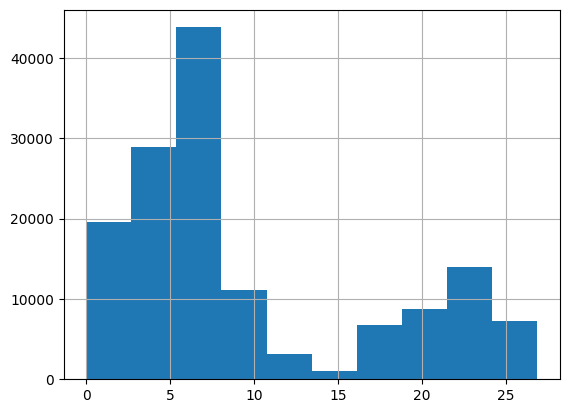

In [120]:
df_1['speed'].hist()

<Axes: >

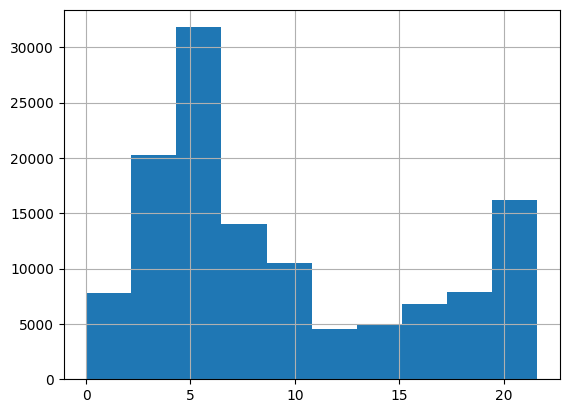

In [121]:
df_2['speed'].hist()

<Axes: >

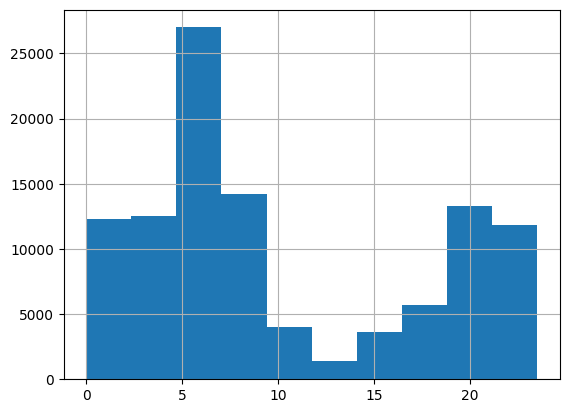

In [122]:
df_3['speed'].hist()

<Axes: >

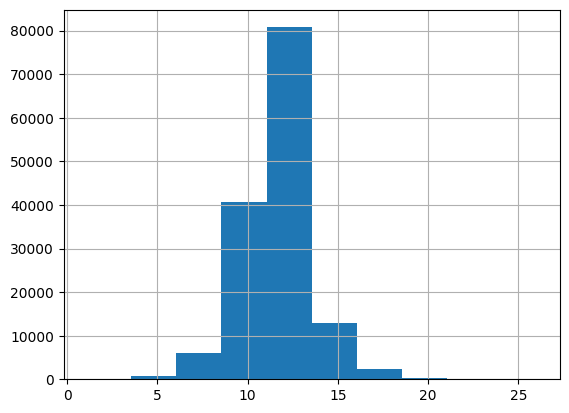

In [123]:
df_1['acc_magnitude_avg'].hist()

<Axes: >

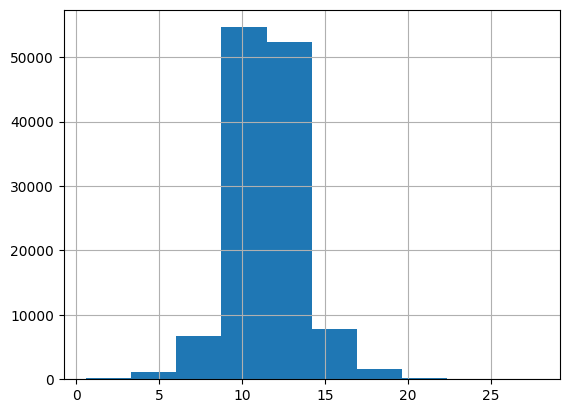

In [124]:
df_2['acc_magnitude_avg'].hist()

<Axes: >

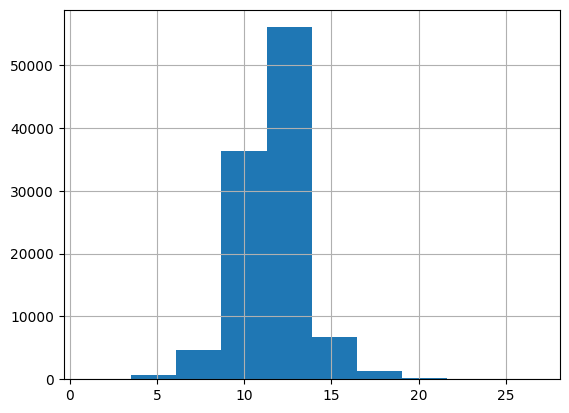

In [125]:
df_3['acc_magnitude_avg'].hist()

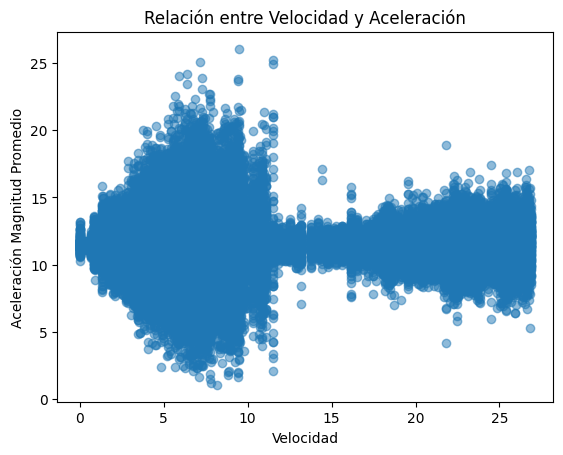

In [126]:
plt.scatter(df_1['speed'], df_1['acc_magnitude_avg'], alpha=0.5)
plt.title('Relación entre Velocidad y Aceleración')
plt.xlabel('Velocidad')
plt.ylabel('Aceleración Magnitud Promedio')
plt.show()

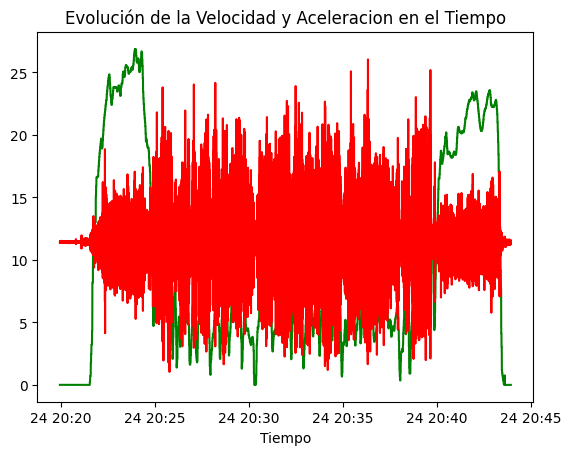

In [127]:
plt.plot(df_1['timestamp'], df_1['speed'], color='green')
plt.plot(df_1['timestamp'], df_1['acc_magnitude_avg'], color='red')
plt.title('Evolución de la Velocidad y Aceleracion en el Tiempo')
plt.xlabel('Tiempo')
plt.show()


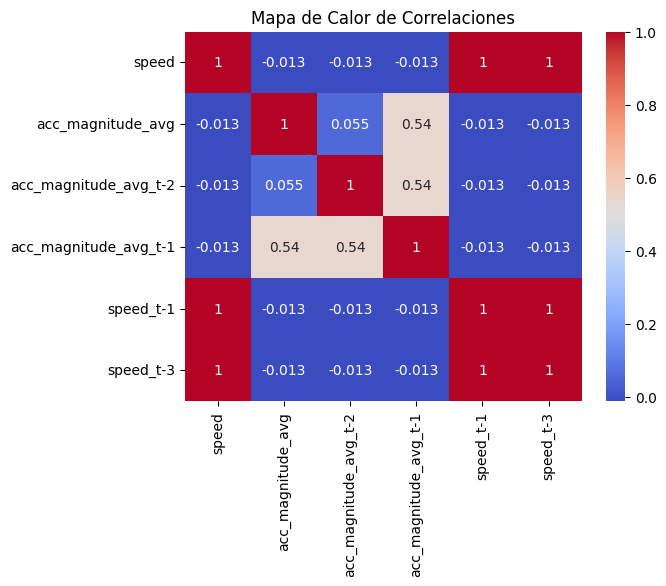

In [128]:
correlation_matrix = df_1[['speed', 'acc_magnitude_avg', 'acc_magnitude_avg_t-2', 'acc_magnitude_avg_t-1', 'speed_t-1','speed_t-3']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

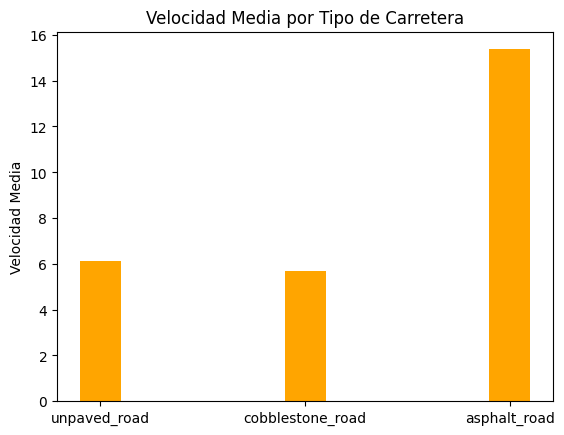

In [129]:
road_types = ['unpaved_road',  'cobblestone_road', 'asphalt_road']
avg_speed = [df_1[df_1[road_type] == 1]['speed'].mean() for road_type in road_types]
bar_width = 0.2
plt.bar(road_types, avg_speed, color='orange',width=bar_width)
plt.title('Velocidad Media por Tipo de Carretera')
plt.ylabel('Velocidad Media')
plt.show()


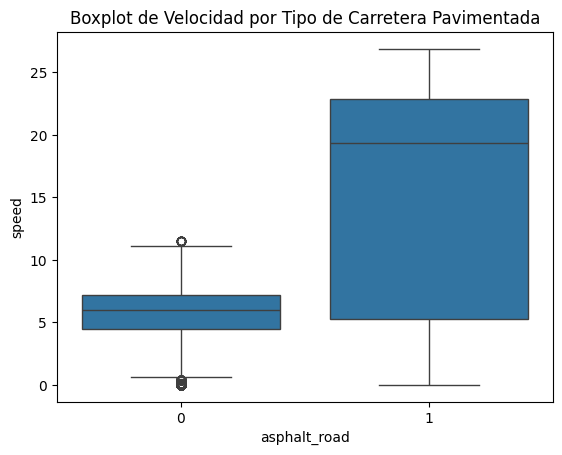

In [130]:
sns.boxplot(x='asphalt_road', y='speed', data=df_1)
plt.title('Boxplot de Velocidad por Tipo de Carretera Pavimentada')
plt.show()


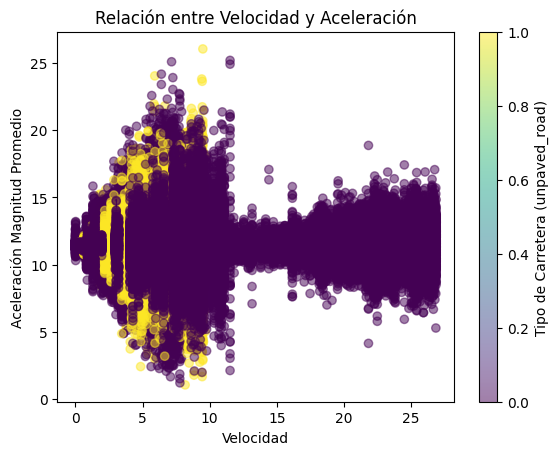

In [131]:
plt.scatter(df_1['speed'], df_1['acc_magnitude_avg'], c=df_1['unpaved_road'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Tipo de Carretera (unpaved_road)')
plt.title('Relación entre Velocidad y Aceleración')
plt.xlabel('Velocidad')
plt.ylabel('Aceleración Magnitud Promedio')
plt.show()


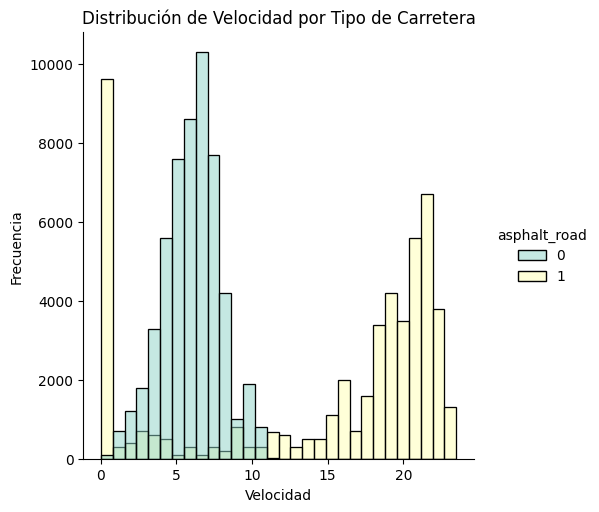

In [132]:
sns.displot(df_3, x='speed', hue='asphalt_road', kind='hist', bins=30, palette='Set3')

plt.title('Distribución de Velocidad por Tipo de Carretera')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia')

plt.show()

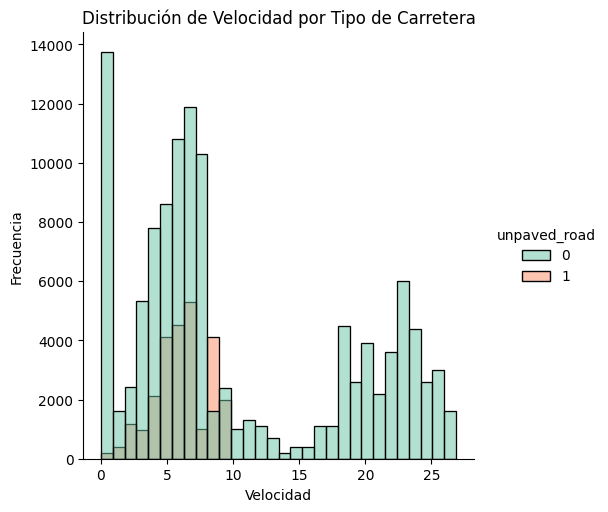

In [133]:
sns.displot(df_1, x='speed', hue='unpaved_road', kind='hist', bins=30, palette='Set2')

plt.title('Distribución de Velocidad por Tipo de Carretera')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia')

plt.show()

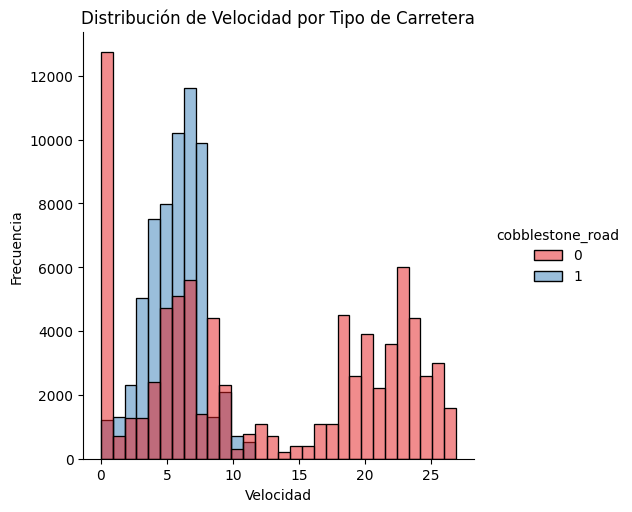

In [134]:
sns.displot(df_1, x='speed', hue='cobblestone_road', kind='hist', bins=30, palette='Set1')

plt.title('Distribución de Velocidad por Tipo de Carretera')
plt.xlabel('Velocidad')
plt.ylabel('Frecuencia')

plt.show()

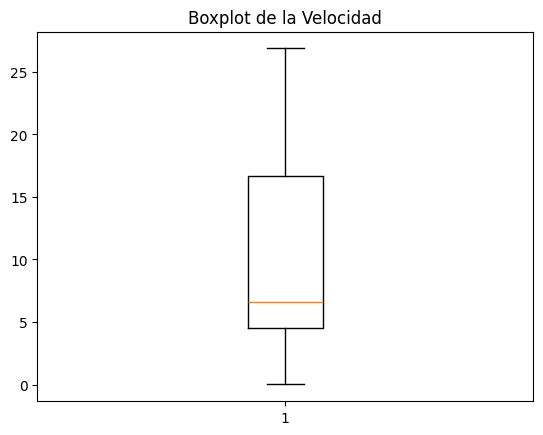

In [135]:
plt.boxplot(df['speed'])
plt.title('Boxplot de la Velocidad')
plt.show()


In [136]:
df_1[df_1['unpaved_road'] == 1]

,timestamp,latitude,longitude,speed,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,...,acc_y_avg,acc_z_avg,acc_magnitude_avg,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3
30831,2019-12-24 20:25:04.869999886,-27.688735,-51.120601,5.651886,0,1,1,0,0,1,...,-2.102309,17.818646,17.944878,-5.783081,3.031413,0.175476,6.531790,15.006071,10.335919,5.824641
30832,2019-12-24 20:25:04.880000114,-27.688735,-51.120601,5.651886,0,1,1,0,0,1,...,-1.400608,14.587073,14.694093,-1.429240,20.055135,3.550212,20.417031,17.944878,15.006071,10.335919
30833,2019-12-24 20:25:04.890000105,-27.688735,-51.120601,5.651886,0,1,1,0,0,1,...,1.325191,11.426726,11.510999,0.157674,22.801717,-2.009074,22.890599,14.694093,17.944878,15.006071
30834,2019-12-24 20:25:04.900000095,-27.688735,-51.120601,5.651886,0,1,1,0,0,1,...,-0.959875,7.431602,7.507852,1.576742,12.807210,-6.764730,14.569568,11.510999,14.694093,17.944878
30835,2019-12-24 20:25:04.910000086,-27.688735,-51.120601,5.651886,0,1,1,0,0,1,...,0.049281,6.877145,7.051023,-0.869751,11.044820,-6.042480,12.619671,7.507852,11.510999,14.694093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109556,2019-12-24 20:38:12.119999886,-27.685149,-51.124409,3.216680,0,1,1,0,0,1,...,0.373096,10.501567,10.514287,2.263387,-9.122213,-11.978149,15.225431,11.637879,12.731603,11.542009
109557,2019-12-24 20:38:12.130000114,-27.685149,-51.124409,3.216680,0,1,1,0,0,1,...,-0.584983,10.804234,10.823757,1.251221,-7.542928,-11.377970,13.708374,10.514287,11.637879,12.731603
109558,2019-12-24 20:38:12.140000105,-27.685149,-51.124409,3.216680,0,1,1,0,0,1,...,-0.775721,10.769518,10.798745,2.268473,-4.501343,-11.459351,12.518977,10.823757,10.514287,11.637879
109559,2019-12-24 20:38:12.150000095,-27.685149,-51.124409,3.216680,0,1,1,0,0,1,...,-0.619300,10.464856,10.485555,3.641764,-3.143311,-12.931824,13.797642,10.798745,10.823757,10.514287


In [137]:
df_3['unpaved_road'].equals(df_3['dirt_road'])

True

In [138]:
df_3['paved_road'].equals(df_3['cobblestone_road'])

False

In [139]:
df_1 = df_1.drop(['dirt_road'],axis = 1)
df_2 = df_2.drop(['dirt_road'],axis = 1)
df_3 = df_3.drop(['dirt_road'],axis = 1)

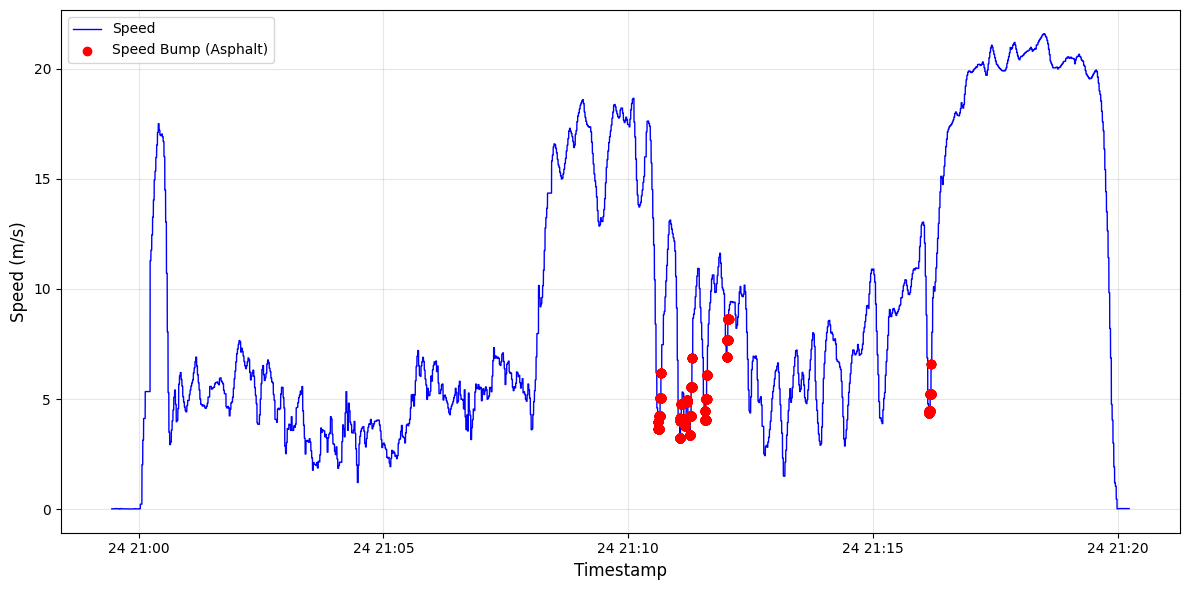

In [140]:
speed_bump_asphalt = df_2[df_2['speed_bump_asphalt'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_2['timestamp'], df_2['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(speed_bump_asphalt['timestamp'], speed_bump_asphalt['speed'], 
            color='red', label='Speed Bump (Asphalt)', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


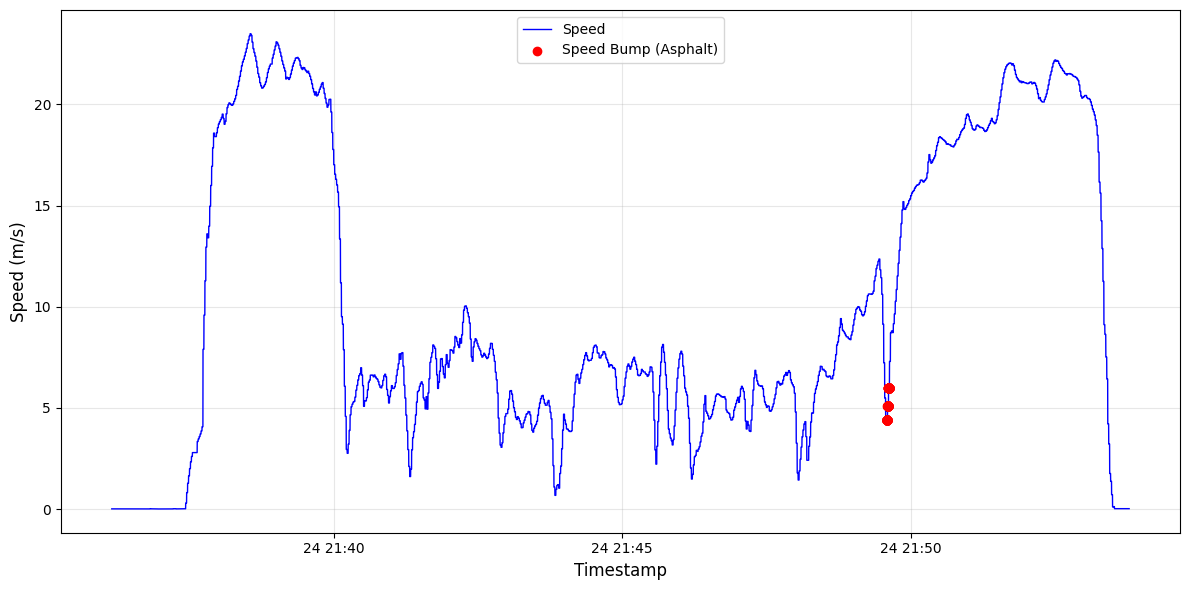

In [141]:
speed_bump_asphalt = df_3[df_3['speed_bump_asphalt'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_3['timestamp'], df_3['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(speed_bump_asphalt['timestamp'], speed_bump_asphalt['speed'], 
            color='red', label='Speed Bump (Asphalt)', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [142]:
df_3['bad_road_right'].equals(df_3['unpaved_road'])

False

In [143]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144032 entries, 3 to 144034
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               144032 non-null  datetime64[ns]
 1   latitude                144032 non-null  float64       
 2   longitude               144032 non-null  float64       
 3   speed                   144032 non-null  float64       
 4   paved_road              144032 non-null  int64         
 5   unpaved_road            144032 non-null  int64         
 6   cobblestone_road        144032 non-null  int64         
 7   asphalt_road            144032 non-null  int64         
 8   no_speed_bump           144032 non-null  int64         
 9   speed_bump_asphalt      144032 non-null  int64         
 10  speed_bump_cobblestone  144032 non-null  int64         
 11  good_road_left          144032 non-null  int64         
 12  regular_road_left       144032 non-

In [144]:
df_1['speed'].quantile([0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.995])

0.005     0.004352
0.050     0.006387
0.100     0.998804
0.200     3.941167
0.300     5.079866
0.400     5.965447
0.500     6.618945
0.600     7.506178
0.700     9.411500
0.800    19.144136
0.900    22.837078
0.950    24.121445
0.995    26.544662
Name: speed, dtype: float64

In [145]:
df_2['speed'].quantile([0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.995])

0.005     0.007969
0.050     1.927806
0.100     2.981896
0.200     4.044873
0.300     4.985330
0.400     5.634662
0.500     6.692151
0.600     8.825022
0.700    11.997314
0.800    17.133026
0.900    19.992666
0.950    20.512396
0.995    21.428179
Name: speed, dtype: float64

In [146]:
df_3['speed'].quantile([0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.995])

0.005     0.005028
0.050     0.009568
0.100     1.432944
0.200     4.330408
0.300     5.393422
0.400     6.360503
0.500     7.145476
0.600     8.468566
0.700    16.125376
0.800    19.523617
0.900    21.325972
0.950    21.916508
0.995    23.079206
Name: speed, dtype: float64

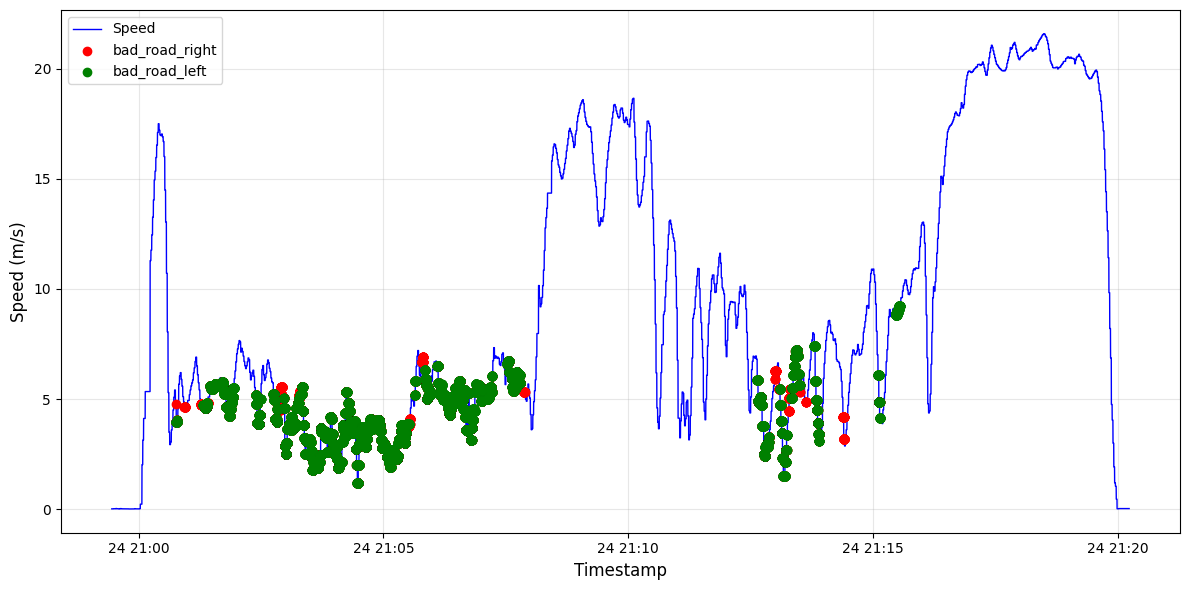

In [147]:
bad_road_right = df_2[df_2['bad_road_right'] == 1]
bad_road_left = df_2[df_2['bad_road_left'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_2['timestamp'], df_2['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(bad_road_right['timestamp'], bad_road_right['speed'], 
            color='red', label='bad_road_right', zorder=5)
plt.scatter(bad_road_left['timestamp'], bad_road_left['speed'], 
            color='green', label='bad_road_left', zorder=5)

plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


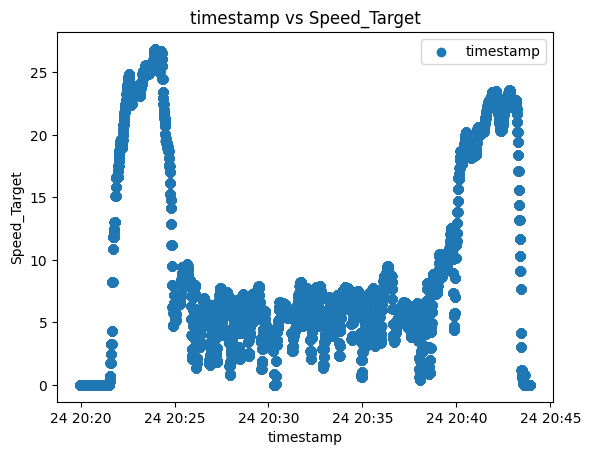

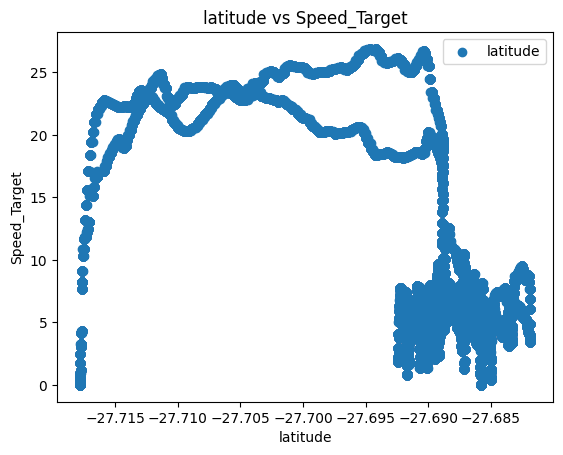

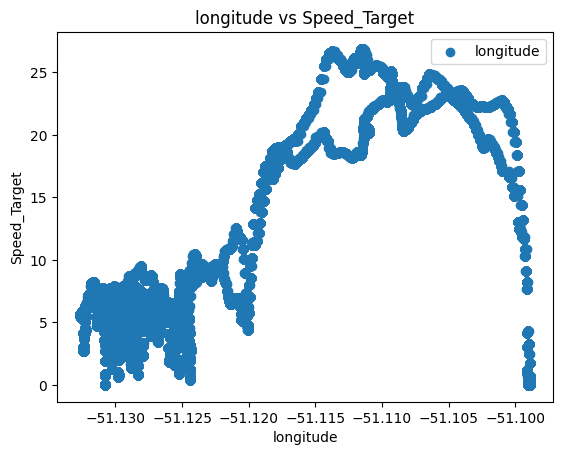

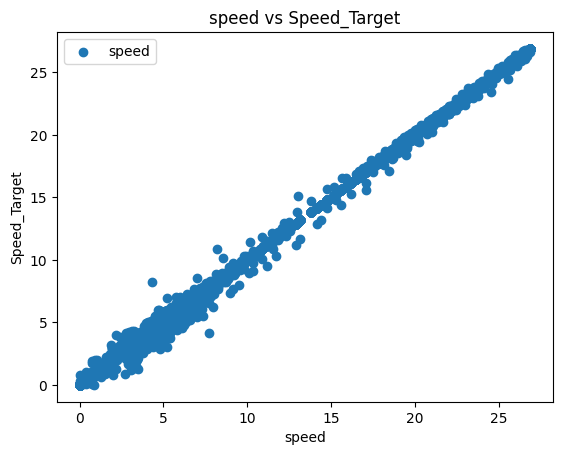

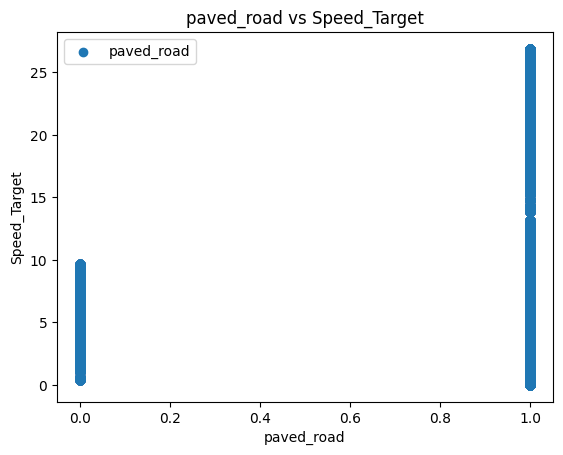

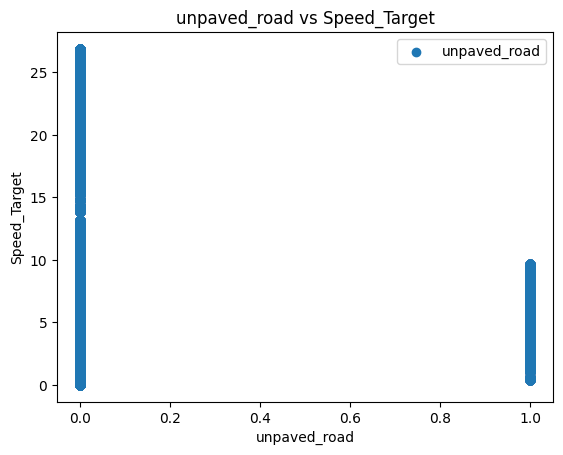

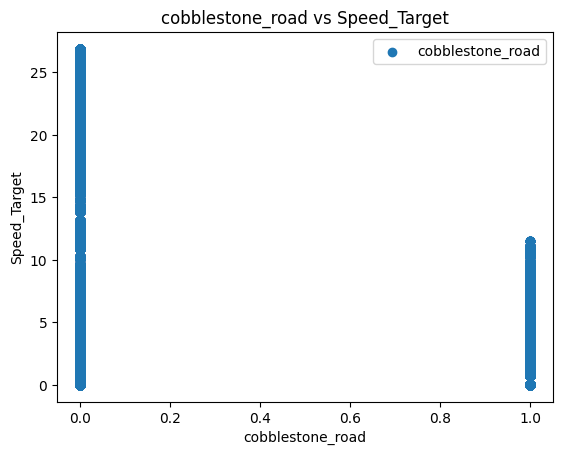

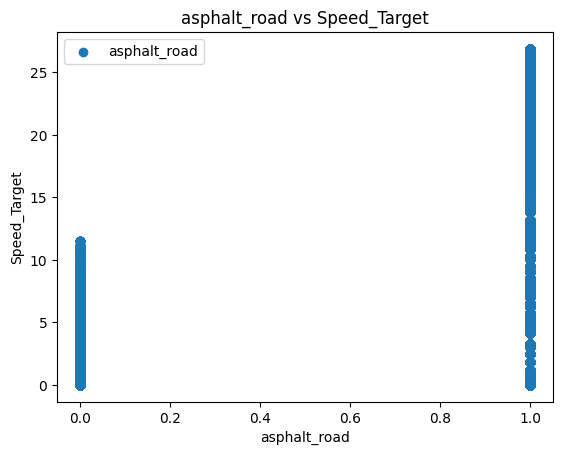

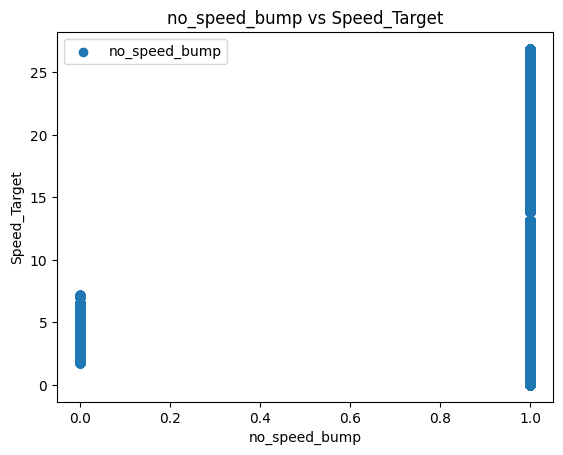

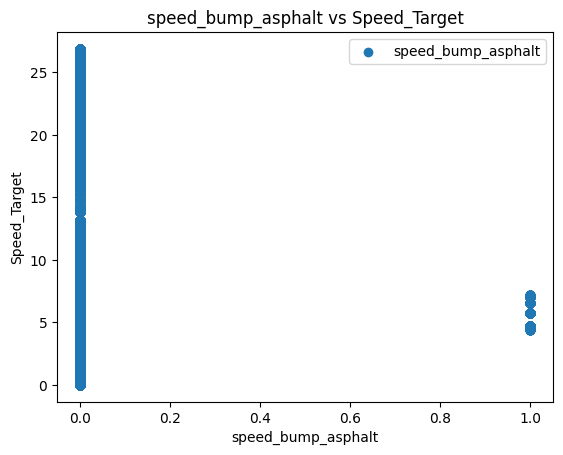

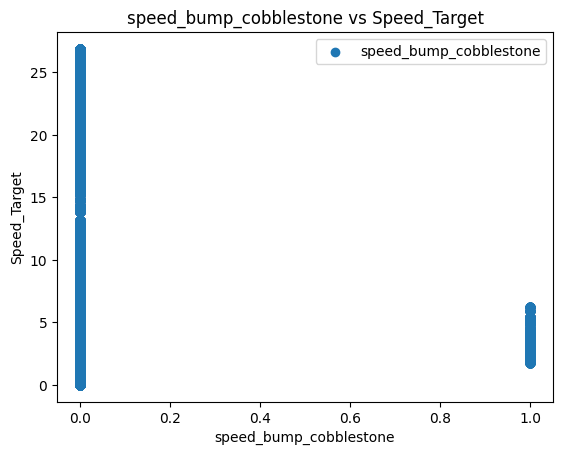

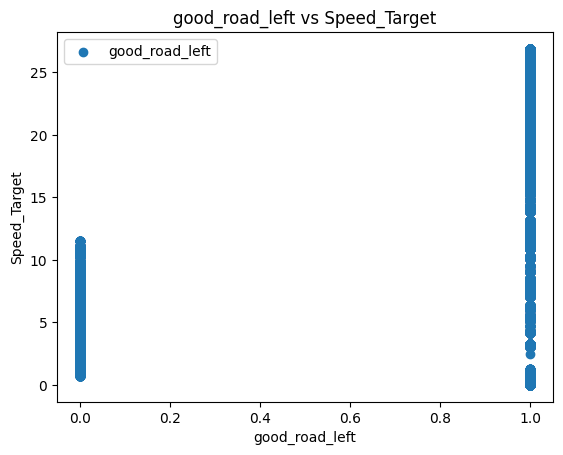

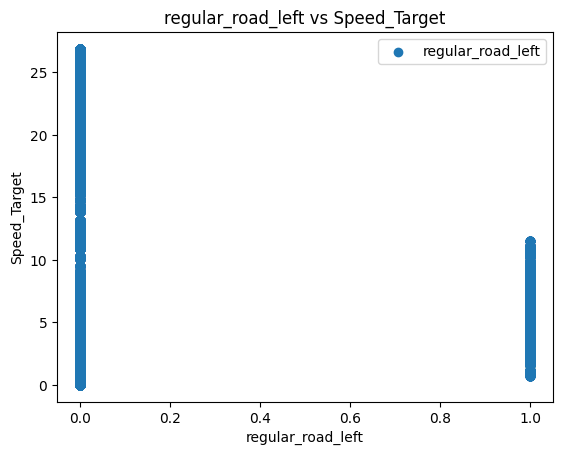

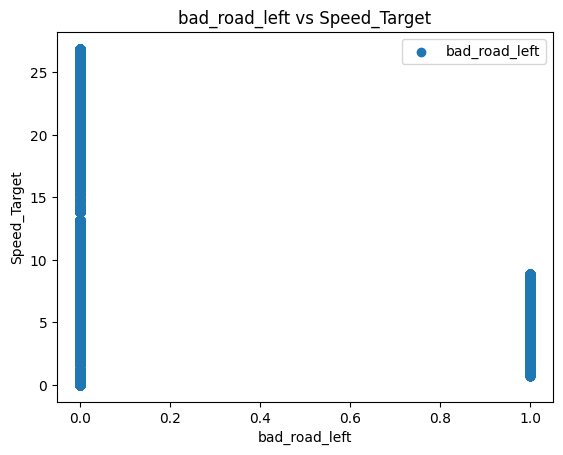

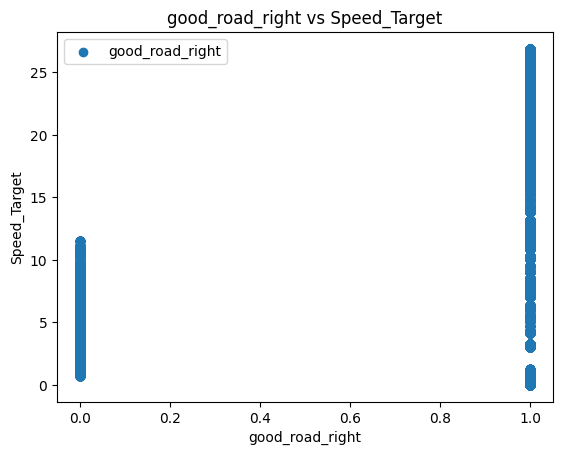

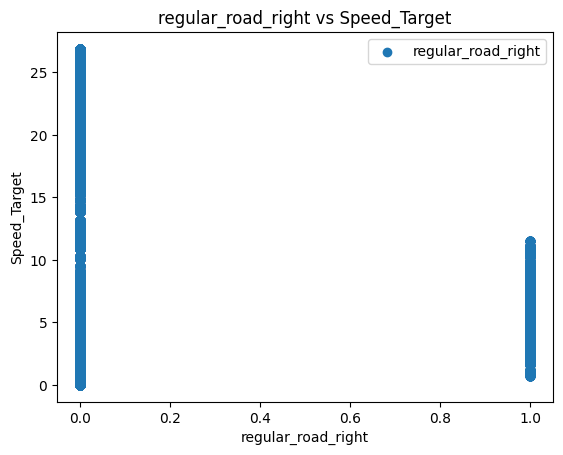

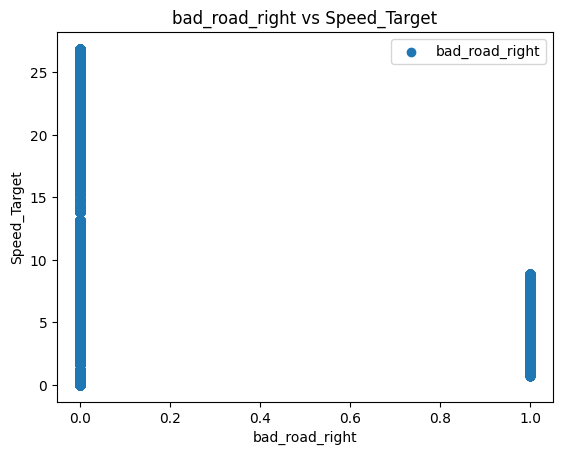

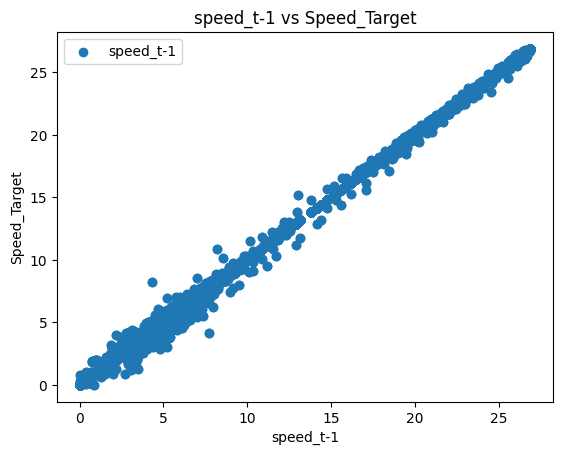

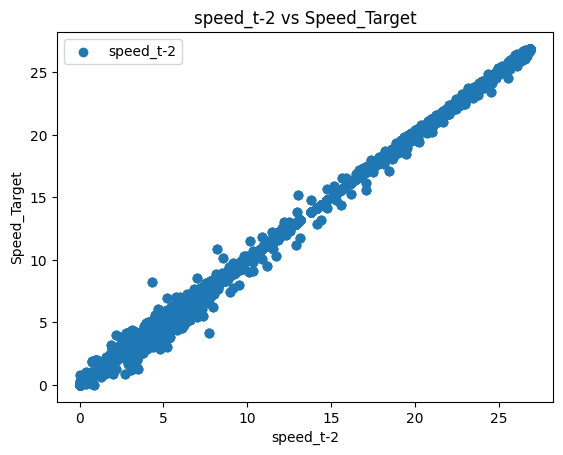

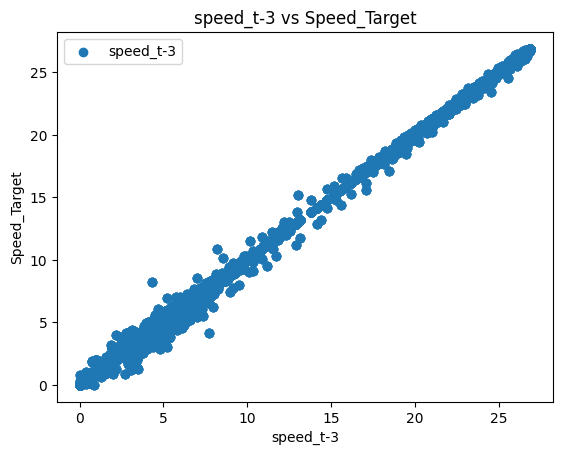

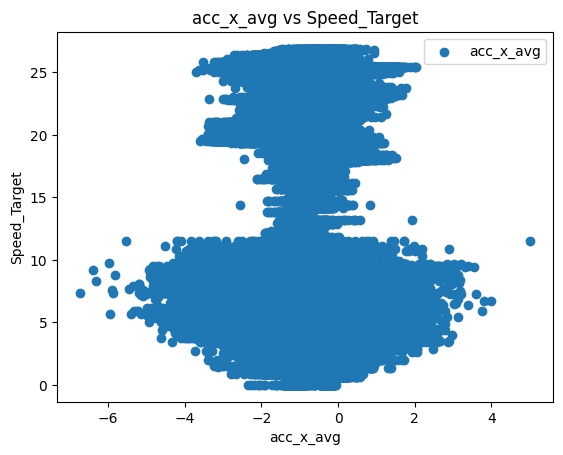

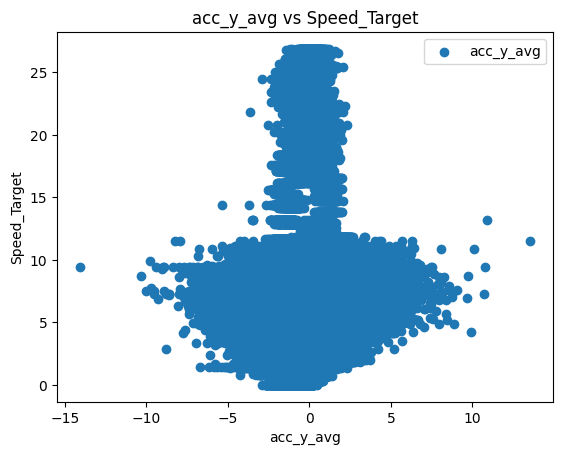

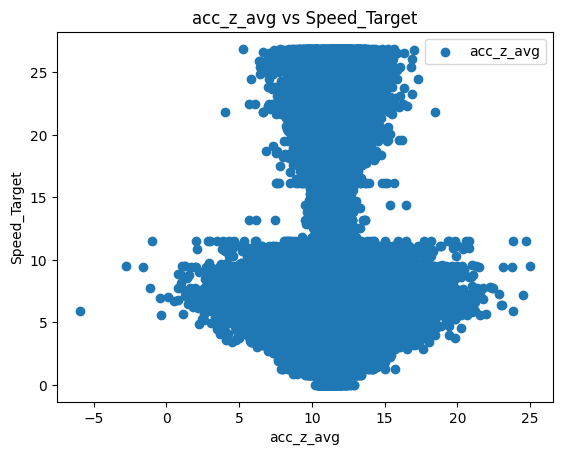

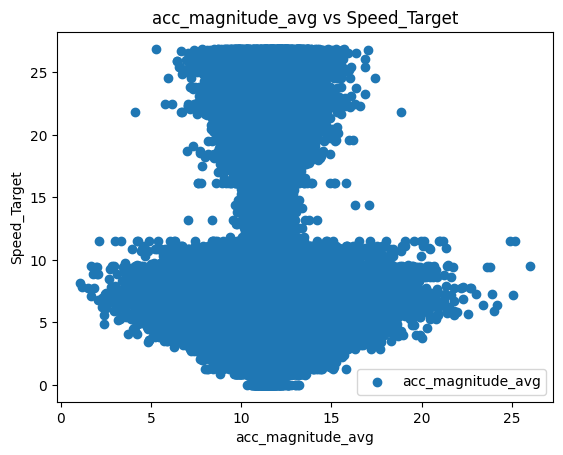

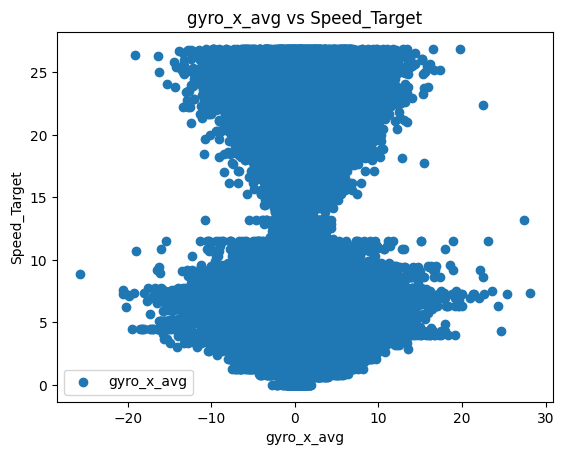

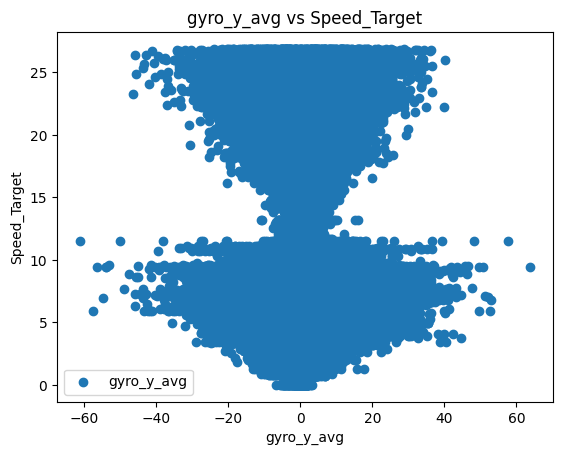

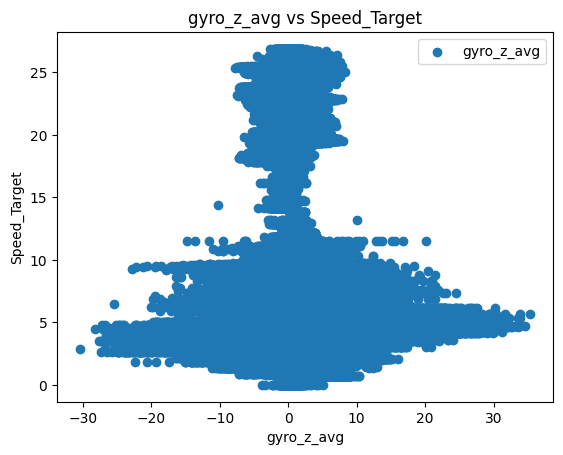

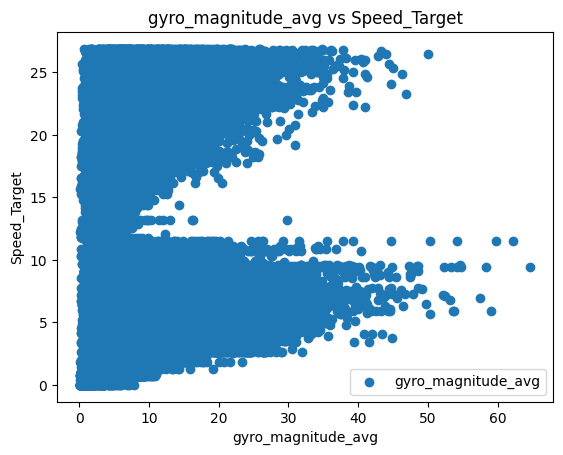

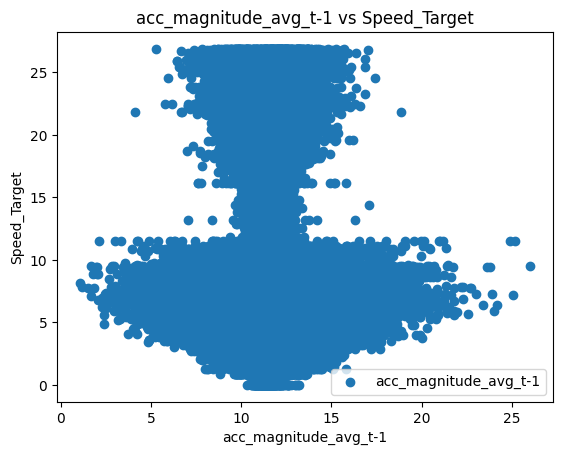

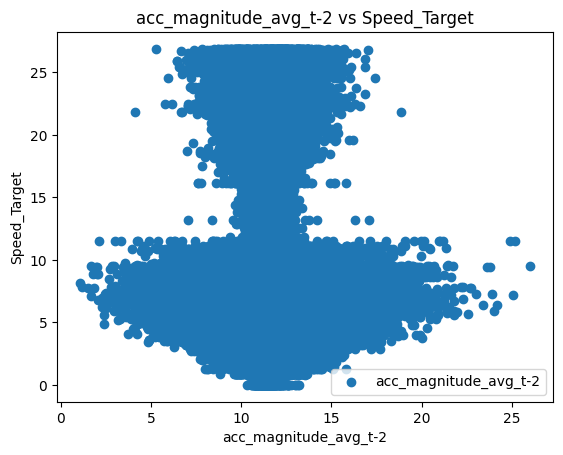

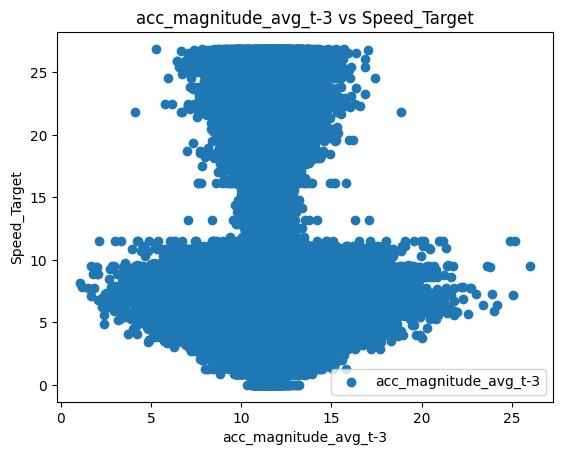

In [148]:
target = 'Speed_Target'

for feature in df_1.columns:
    if feature != target:
        plt.scatter(df_1[feature],df_1[target],label = feature)
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"{feature} vs {target}")
        plt.legend()
        plt.show()

    

In [149]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105812 entries, 3 to 105814
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               105812 non-null  datetime64[ns]
 1   latitude                105812 non-null  float64       
 2   longitude               105812 non-null  float64       
 3   speed                   105812 non-null  float64       
 4   paved_road              105812 non-null  int64         
 5   unpaved_road            105812 non-null  int64         
 6   cobblestone_road        105812 non-null  int64         
 7   asphalt_road            105812 non-null  int64         
 8   no_speed_bump           105812 non-null  int64         
 9   speed_bump_asphalt      105812 non-null  int64         
 10  speed_bump_cobblestone  105812 non-null  int64         
 11  good_road_left          105812 non-null  int64         
 12  regular_road_left       105812 non-

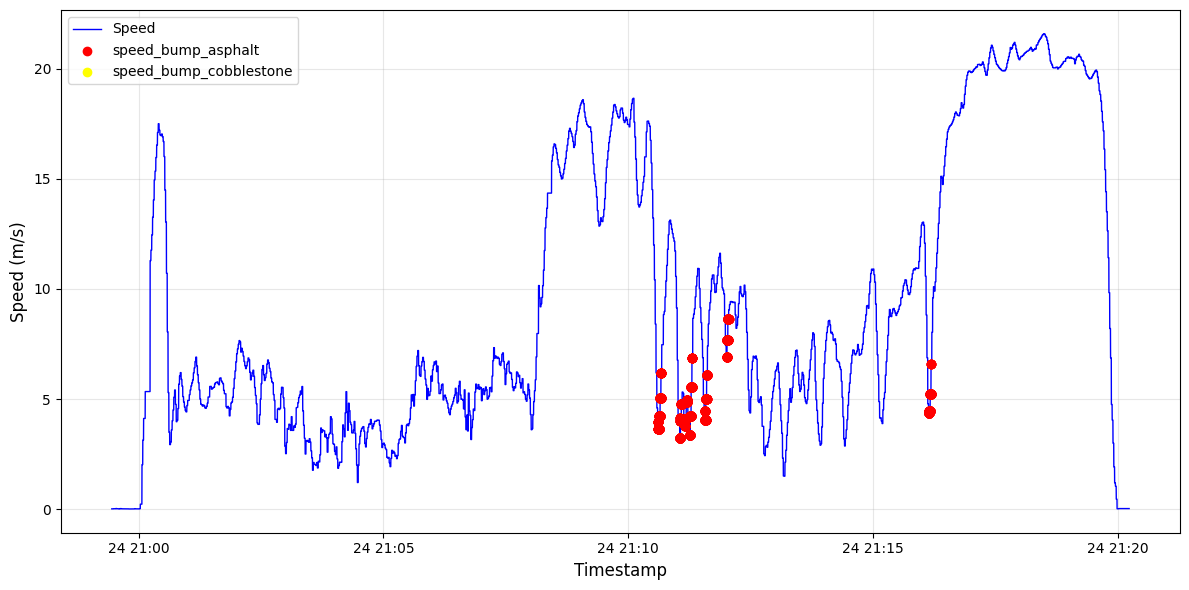

In [150]:
no_speed_bump = df_2[df_2['no_speed_bump'] == 1] 
speed_bump_asphalt = df_2[df_2['speed_bump_asphalt'] == 1] 
speed_bump_cobblestone = df_2[df_2['speed_bump_cobblestone'] == 1] 

plt.figure(figsize=(12, 6))
plt.plot(df_2['timestamp'], df_2['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(speed_bump_asphalt['timestamp'], speed_bump_asphalt['speed'], 
            color='red', label='speed_bump_asphalt', zorder=5)
plt.scatter(speed_bump_cobblestone['timestamp'], speed_bump_cobblestone['speed'], 
            color='yellow', label='speed_bump_cobblestone', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


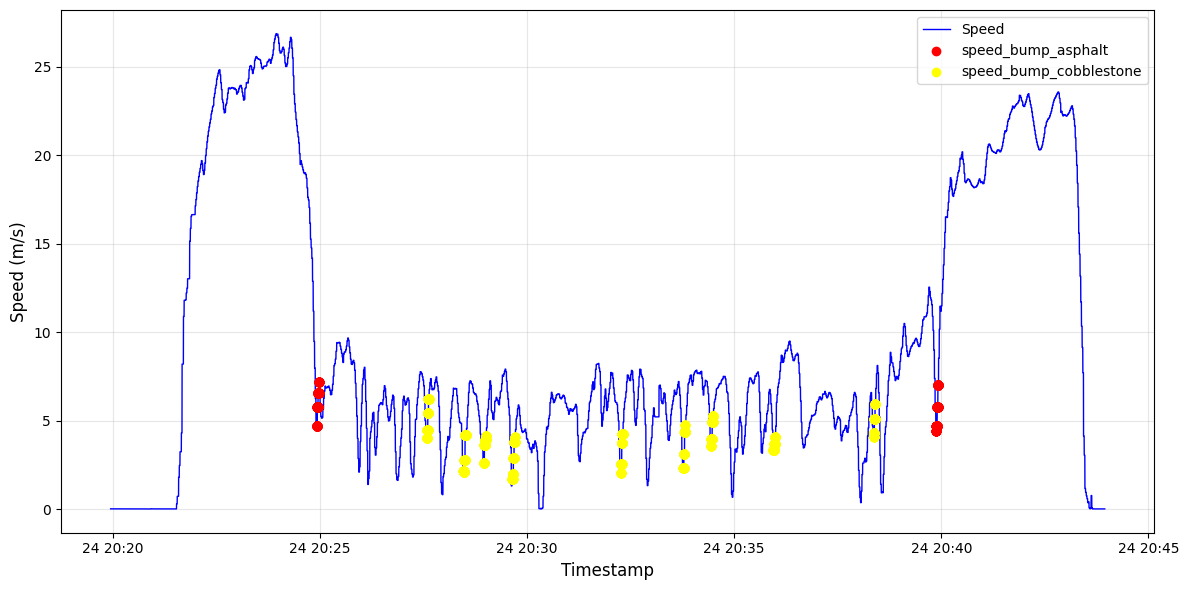

In [151]:
no_speed_bump = df_1[df_1['no_speed_bump'] == 1] 
speed_bump_asphalt = df_1[df_1['speed_bump_asphalt'] == 1] 
speed_bump_cobblestone = df_1[df_1['speed_bump_cobblestone'] == 1] 

plt.figure(figsize=(12, 6))
plt.plot(df_1['timestamp'], df_1['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(speed_bump_asphalt['timestamp'], speed_bump_asphalt['speed'], 
            color='red', label='speed_bump_asphalt', zorder=5)
plt.scatter(speed_bump_cobblestone['timestamp'], speed_bump_cobblestone['speed'], 
            color='yellow', label='speed_bump_cobblestone', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


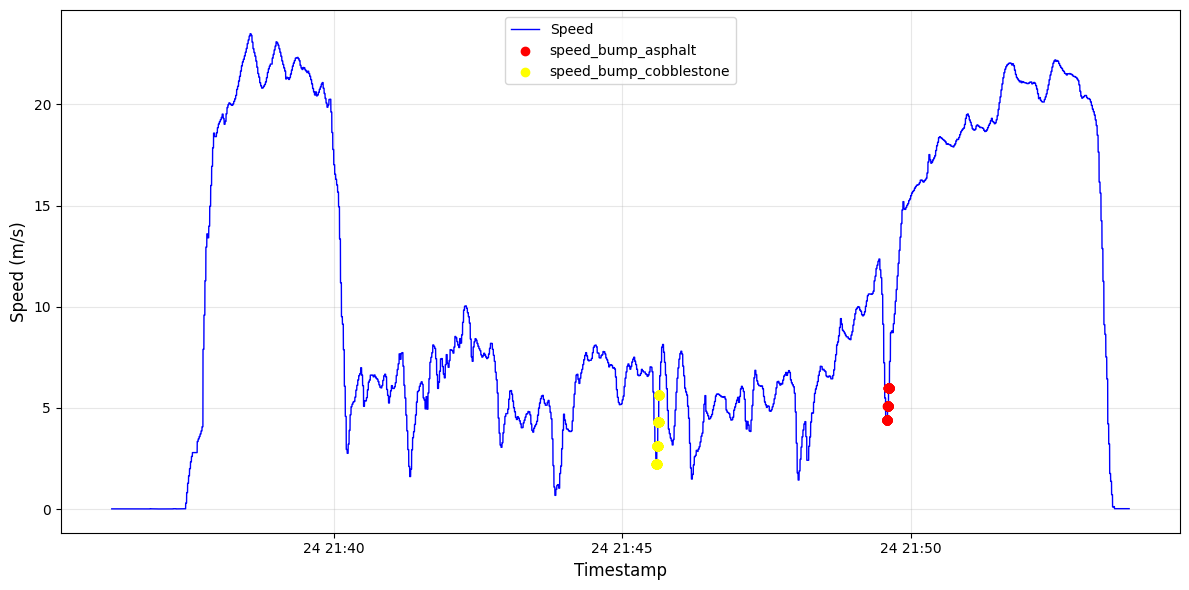

In [152]:
no_speed_bump = df_3[df_3['no_speed_bump'] == 1]                    # Como era de esperarse con topes la velocidad baja
speed_bump_asphalt = df_3[df_3['speed_bump_asphalt'] == 1]          # pero no parece haber diferencia entre el tipo de material del tope
speed_bump_cobblestone = df_3[df_3['speed_bump_cobblestone'] == 1] 

plt.figure(figsize=(12, 6))
plt.plot(df_3['timestamp'], df_3['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(speed_bump_asphalt['timestamp'], speed_bump_asphalt['speed'], 
            color='red', label='speed_bump_asphalt', zorder=5)
plt.scatter(speed_bump_cobblestone['timestamp'], speed_bump_cobblestone['speed'], 
            color='yellow', label='speed_bump_cobblestone', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


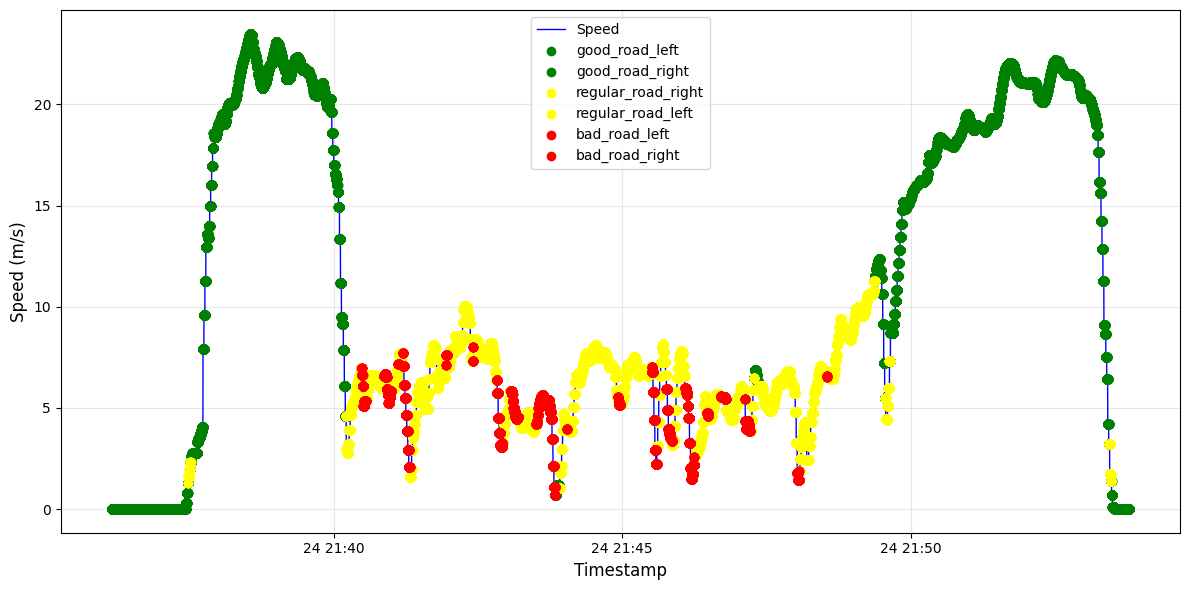

In [153]:
regular_road_right = df_3[df_3['regular_road_right'] == 1] 
regular_road_left = df_3[df_3['regular_road_left'] == 1] 
good_road_left = df_3[df_3['good_road_left'] == 1] 
good_road_right = df_3[df_3['good_road_right'] == 1] 
bad_road_right = df_3[df_3['bad_road_right'] == 1]
bad_road_left = df_3[df_3['bad_road_left'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_3['timestamp'], df_3['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(good_road_left['timestamp'], good_road_left['speed'], 
            color='green', label='good_road_left', zorder=5)
plt.scatter(good_road_right['timestamp'], good_road_right['speed'], 
            color='green', label='good_road_right', zorder=5)
plt.scatter(regular_road_right['timestamp'], regular_road_right['speed'], 
            color='yellow', label='regular_road_right', zorder=5)
plt.scatter(regular_road_left['timestamp'], regular_road_left['speed'], 
            color='yellow', label='regular_road_left', zorder=5)
plt.scatter(bad_road_left['timestamp'], bad_road_left['speed'], 
            color='red', label='bad_road_left', zorder=5)
plt.scatter(bad_road_right['timestamp'], bad_road_right['speed'], 
            color='red', label='bad_road_right', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

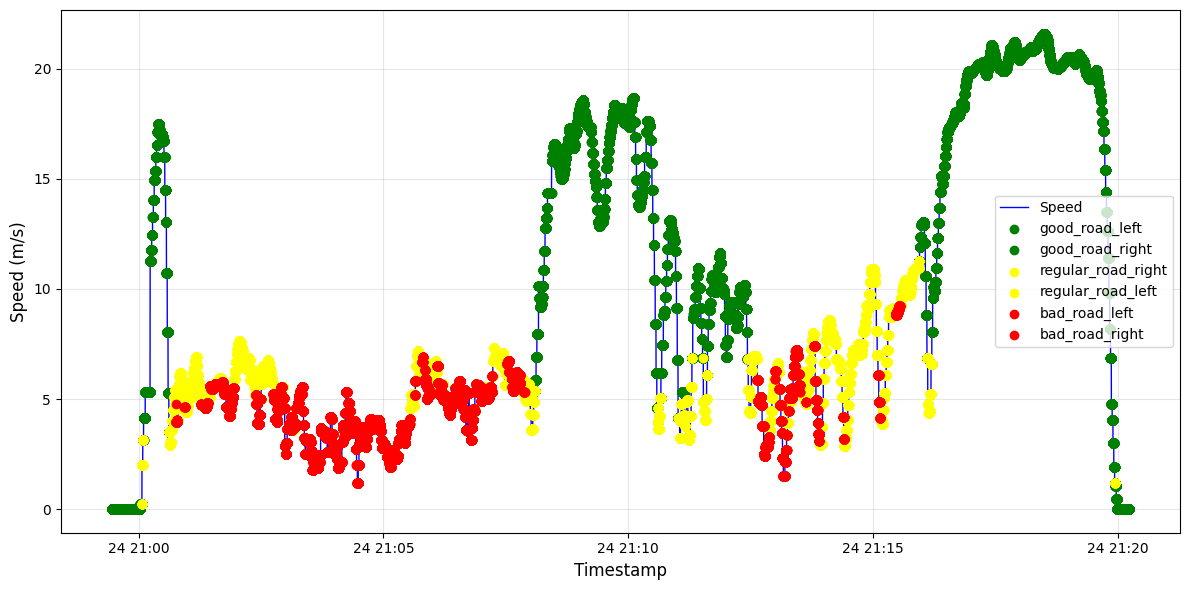

In [154]:
regular_road_right = df_2[df_2['regular_road_right'] == 1] 
regular_road_left = df_2[df_2['regular_road_left'] == 1] 
good_road_left = df_2[df_2['good_road_left'] == 1] 
good_road_right = df_2[df_2['good_road_right'] == 1] 
bad_road_right = df_2[df_2['bad_road_right'] == 1]
bad_road_left = df_2[df_2['bad_road_left'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_2['timestamp'], df_2['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(good_road_left['timestamp'], good_road_left['speed'], 
            color='green', label='good_road_left', zorder=5)
plt.scatter(good_road_right['timestamp'], good_road_right['speed'], 
            color='green', label='good_road_right', zorder=5)
plt.scatter(regular_road_right['timestamp'], regular_road_right['speed'], 
            color='yellow', label='regular_road_right', zorder=5)
plt.scatter(regular_road_left['timestamp'], regular_road_left['speed'], 
            color='yellow', label='regular_road_left', zorder=5)
plt.scatter(bad_road_left['timestamp'], bad_road_left['speed'], 
            color='red', label='bad_road_left', zorder=5)
plt.scatter(bad_road_right['timestamp'], bad_road_right['speed'], 
            color='red', label='bad_road_right', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

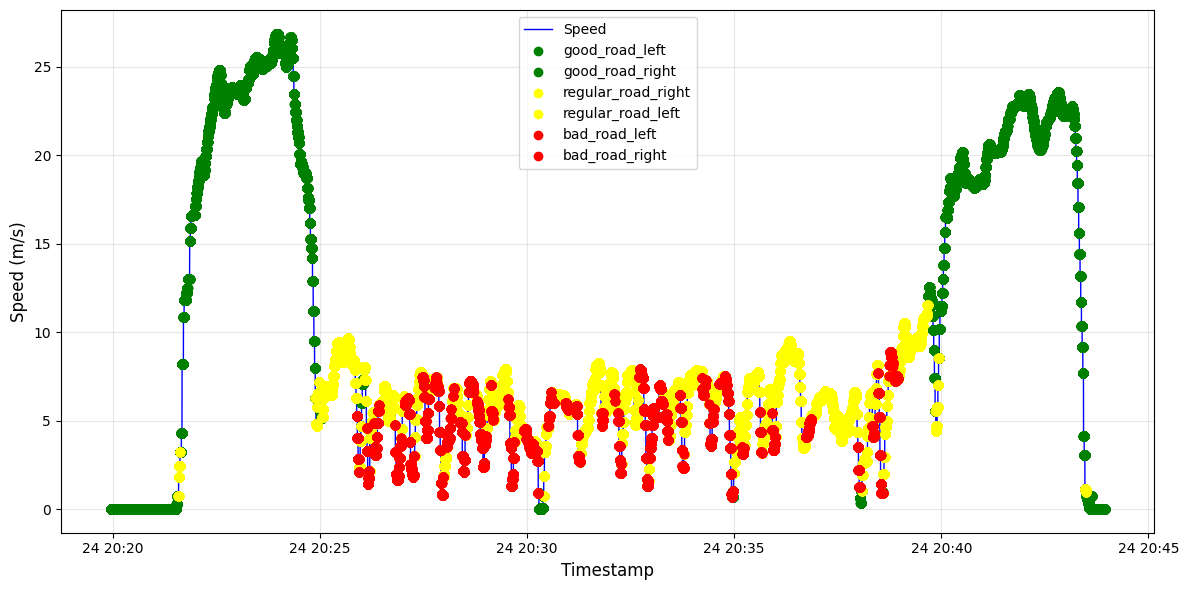

In [155]:
regular_road_right = df_1[df_1['regular_road_right'] == 1] # Despues de las visualizaciones podemos juntar las opciones
regular_road_left = df_1[df_1['regular_road_left'] == 1]   # por lado de god_road, regular_road y bad_road 
good_road_left = df_1[df_1['good_road_left'] == 1] 
good_road_right = df_1[df_1['good_road_right'] == 1] 
bad_road_right = df_1[df_1['bad_road_right'] == 1]
bad_road_left = df_1[df_1['bad_road_left'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_1['timestamp'], df_1['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(good_road_left['timestamp'], good_road_left['speed'], 
            color='green', label='good_road_left', zorder=5)
plt.scatter(good_road_right['timestamp'], good_road_right['speed'], 
            color='green', label='good_road_right', zorder=5)
plt.scatter(regular_road_right['timestamp'], regular_road_right['speed'], 
            color='yellow', label='regular_road_right', zorder=5)
plt.scatter(regular_road_left['timestamp'], regular_road_left['speed'], 
            color='yellow', label='regular_road_left', zorder=5)
plt.scatter(bad_road_left['timestamp'], bad_road_left['speed'], 
            color='red', label='bad_road_left', zorder=5)
plt.scatter(bad_road_right['timestamp'], bad_road_right['speed'], 
            color='red', label='bad_road_right', zorder=5)


plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

In [156]:
df_1['good_road'] = df_1[['good_road_left','good_road_right']].max(axis=1)
df_1['regular_road'] = df_1[['regular_road_left','regular_road_right']].max(axis=1)
df_1["bad_road"] = df_1[["bad_road_left", "bad_road_right"]].max(axis=1)
df_2['good_road'] = df_2[['good_road_left','good_road_right']].max(axis=1)
df_2['regular_road'] = df_2[['regular_road_left','regular_road_right']].max(axis=1)
df_2["bad_road"] = df_2[["bad_road_left", "bad_road_right"]].max(axis=1)
df_3['good_road'] = df_3[['good_road_left','good_road_right']].max(axis=1)
df_3['regular_road'] = df_3[['regular_road_left','regular_road_right']].max(axis=1)
df_3["bad_road"] = df_3[["bad_road_left", "bad_road_right"]].max(axis=1)

In [157]:
df_1.drop(columns=["good_road_left", "good_road_right",
                 "regular_road_left", "regular_road_right",
                 "bad_road_left", "bad_road_right"], inplace=True)
df_2.drop(columns=["good_road_left", "good_road_right",
                 "regular_road_left", "regular_road_right",
                 "bad_road_left", "bad_road_right"], inplace=True)
df_3.drop(columns=["good_road_left", "good_road_right",
                 "regular_road_left", "regular_road_right",
                 "bad_road_left", "bad_road_right"], inplace=True)


In [158]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144032 entries, 3 to 144034
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               144032 non-null  datetime64[ns]
 1   latitude                144032 non-null  float64       
 2   longitude               144032 non-null  float64       
 3   speed                   144032 non-null  float64       
 4   paved_road              144032 non-null  int64         
 5   unpaved_road            144032 non-null  int64         
 6   cobblestone_road        144032 non-null  int64         
 7   asphalt_road            144032 non-null  int64         
 8   no_speed_bump           144032 non-null  int64         
 9   speed_bump_asphalt      144032 non-null  int64         
 10  speed_bump_cobblestone  144032 non-null  int64         
 11  Speed_Target            144032 non-null  float64       
 12  speed_t-1               144032 non-

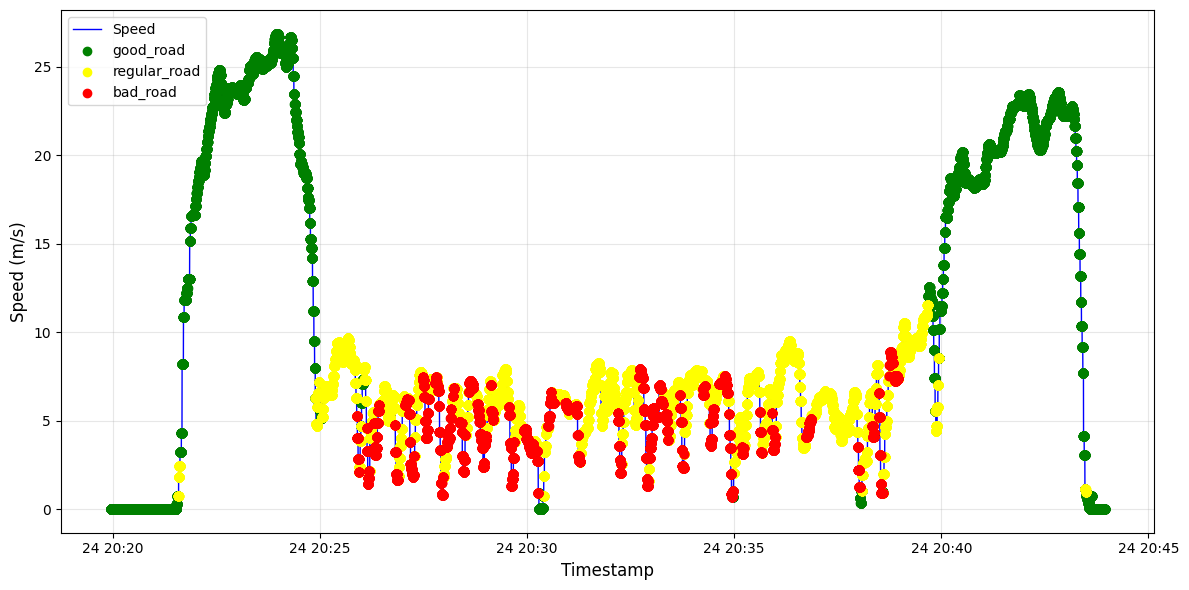

In [159]:
regular_road = df_1[df_1['regular_road'] == 1] 
good_road = df_1[df_1['good_road'] == 1] 
bad_road = df_1[df_1['bad_road'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_1['timestamp'], df_1['speed'], label='Speed', color='blue', linewidth=1)
plt.scatter(good_road_left['timestamp'], good_road_left['speed'], 
            color='green', label='good_road', zorder=5)
plt.scatter(regular_road_left['timestamp'], regular_road_left['speed'], 
            color='yellow', label='regular_road', zorder=5)
plt.scatter(bad_road_left['timestamp'], bad_road_left['speed'], 
            color='red', label='bad_road', zorder=5)

plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

In [160]:
df_3[df_3['paved_road']==1]

,timestamp,latitude,longitude,speed,paved_road,unpaved_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,...,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3,good_road,regular_road,bad_road
3,2019-12-24 21:36:09.210000038,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.432332,-0.007629,0.315348,0.535177,11.385859,11.398455,11.391433,1,0,0
4,2019-12-24 21:36:09.220000029,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.457764,0.167847,0.208537,0.530290,11.392102,11.385859,11.398455,1,0,0
5,2019-12-24 21:36:09.230000019,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.478109,0.203451,0.282288,0.591326,11.412068,11.392102,11.385859,1,0,0
6,2019-12-24 21:36:09.240000010,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.406901,0.183105,0.172933,0.478541,11.414516,11.412068,11.392102,1,0,0
7,2019-12-24 21:36:09.250000000,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.445048,0.109355,0.256856,0.525358,11.426596,11.414516,11.412068,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105810,2019-12-24 21:53:47.279999971,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.409444,0.083923,0.261943,0.493256,11.391147,11.393058,11.377923,1,0,0
105811,2019-12-24 21:53:47.289999962,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.315348,0.114441,0.310262,0.456951,11.384780,11.391147,11.393058,1,0,0
105812,2019-12-24 21:53:47.299999952,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.437419,0.137329,0.295003,0.545180,11.422132,11.384780,11.391147,1,0,0
105813,2019-12-24 21:53:47.309999943,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.340780,0.106812,0.264486,0.444401,11.413420,11.422132,11.384780,1,0,0


In [161]:
df_3[df_3['cobblestone_road']==1]

,timestamp,latitude,longitude,speed,paved_road,unpaved_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,...,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3,good_road,regular_road,bad_road
48210,2019-12-24 21:44:11.279999971,-27.691010,-51.123088,6.270536,1,0,1,0,1,0,...,4.117330,35.247803,-0.544230,35.491635,13.182528,14.386530,13.223090,0,1,0
48211,2019-12-24 21:44:11.289999962,-27.691010,-51.123088,6.270536,1,0,1,0,1,0,...,1.370748,25.822957,-0.953674,25.876893,12.842577,13.182528,14.386530,0,1,0
48212,2019-12-24 21:44:11.299999952,-27.691010,-51.123088,6.270536,1,0,1,0,1,0,...,-2.649943,23.577372,-5.162557,24.280994,9.578647,12.842577,13.182528,0,1,0
48213,2019-12-24 21:44:11.309999943,-27.691010,-51.123088,6.270536,1,0,1,0,1,0,...,-5.666097,10.932922,-11.754354,17.023463,8.669355,9.578647,12.842577,0,1,0
48214,2019-12-24 21:44:11.319999933,-27.691010,-51.123088,6.270536,1,0,1,0,1,0,...,-4.913330,-1.129150,-11.698405,12.738464,12.082434,8.669355,9.578647,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,2019-12-24 21:49:22.099999905,-27.688249,-51.121164,11.280288,1,0,1,0,1,0,...,9.709676,-6.782532,2.909342,12.196099,8.610547,11.954639,13.246539,0,1,0
79293,2019-12-24 21:49:22.109999895,-27.688249,-51.121164,11.280288,1,0,1,0,1,0,...,6.220500,-13.903300,3.918966,15.727513,8.904572,8.610547,11.954639,0,1,0
79294,2019-12-24 21:49:22.119999886,-27.688249,-51.121164,11.280288,1,0,1,0,1,0,...,4.659017,-2.487183,2.065023,5.670700,6.889315,8.904572,8.610547,0,1,0
79295,2019-12-24 21:49:22.130000114,-27.688249,-51.121164,11.280288,1,0,1,0,1,0,...,2.820333,-7.415771,0.045776,7.934106,9.283016,6.889315,8.904572,0,1,0


In [162]:
df_3[df_3['asphalt_road']==1] # Podemos ver que paved_road, es la suma de los datos de asphalt_road y coblestone_road
                              # por lo que podemos quitar paved_road

,timestamp,latitude,longitude,speed,paved_road,unpaved_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,...,gyro_x_avg,gyro_y_avg,gyro_z_avg,gyro_magnitude_avg,acc_magnitude_avg_t-1,acc_magnitude_avg_t-2,acc_magnitude_avg_t-3,good_road,regular_road,bad_road
3,2019-12-24 21:36:09.210000038,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.432332,-0.007629,0.315348,0.535177,11.385859,11.398455,11.391433,1,0,0
4,2019-12-24 21:36:09.220000029,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.457764,0.167847,0.208537,0.530290,11.392102,11.385859,11.398455,1,0,0
5,2019-12-24 21:36:09.230000019,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.478109,0.203451,0.282288,0.591326,11.412068,11.392102,11.385859,1,0,0
6,2019-12-24 21:36:09.240000010,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.406901,0.183105,0.172933,0.478541,11.414516,11.412068,11.392102,1,0,0
7,2019-12-24 21:36:09.250000000,-27.717713,-51.099037,0.008459,1,0,0,1,1,0,...,0.445048,0.109355,0.256856,0.525358,11.426596,11.414516,11.412068,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105810,2019-12-24 21:53:47.279999971,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.409444,0.083923,0.261943,0.493256,11.391147,11.393058,11.377923,1,0,0
105811,2019-12-24 21:53:47.289999962,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.315348,0.114441,0.310262,0.456951,11.384780,11.391147,11.393058,1,0,0
105812,2019-12-24 21:53:47.299999952,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.437419,0.137329,0.295003,0.545180,11.422132,11.384780,11.391147,1,0,0
105813,2019-12-24 21:53:47.309999943,-27.717802,-51.099076,0.018415,1,0,0,1,1,0,...,0.340780,0.106812,0.264486,0.444401,11.413420,11.422132,11.384780,1,0,0


In [163]:
df_1.drop(columns = ['paved_road'],inplace = True)
df_2.drop(columns = ['paved_road'],inplace = True)
df_3.drop(columns = ['paved_road'],inplace = True)

In [164]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144032 entries, 3 to 144034
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               144032 non-null  datetime64[ns]
 1   latitude                144032 non-null  float64       
 2   longitude               144032 non-null  float64       
 3   speed                   144032 non-null  float64       
 4   unpaved_road            144032 non-null  int64         
 5   cobblestone_road        144032 non-null  int64         
 6   asphalt_road            144032 non-null  int64         
 7   no_speed_bump           144032 non-null  int64         
 8   speed_bump_asphalt      144032 non-null  int64         
 9   speed_bump_cobblestone  144032 non-null  int64         
 10  Speed_Target            144032 non-null  float64       
 11  speed_t-1               144032 non-null  float64       
 12  speed_t-2               144032 non-

In [165]:
df_1['speed_bump'] = (df_1["speed_bump_asphalt"] | df_1["speed_bump_cobblestone"]).astype(int)
df_2['speed_bump'] = (df_2["speed_bump_asphalt"] | df_2["speed_bump_cobblestone"]).astype(int)
df_3['speed_bump'] = (df_3["speed_bump_asphalt"] | df_3["speed_bump_cobblestone"]).astype(int)

In [166]:
df_1.drop(columns = ['speed_bump_asphalt','speed_bump_cobblestone'],inplace = True)
df_2.drop(columns = ['speed_bump_asphalt','speed_bump_cobblestone'],inplace = True)
df_3.drop(columns = ['speed_bump_asphalt','speed_bump_cobblestone'],inplace = True)

In [177]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105812 entries, 3 to 105814
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   timestamp              105812 non-null  datetime64[ns]
 1   latitude               105812 non-null  float64       
 2   longitude              105812 non-null  float64       
 3   speed                  105812 non-null  float64       
 4   unpaved_road           105812 non-null  int64         
 5   cobblestone_road       105812 non-null  int64         
 6   asphalt_road           105812 non-null  int64         
 7   no_speed_bump          105812 non-null  int64         
 8   Speed_Target           105812 non-null  float64       
 9   speed_t-1              105812 non-null  float64       
 10  speed_t-2              105812 non-null  float64       
 11  speed_t-3              105812 non-null  float64       
 12  acc_x_avg              105812 non-null  float64  

In [172]:
m = folium.Map(location=[df_1['latitude'].mean(), df_1['longitude'].mean()], zoom_start=12)

color_map = {
    0: 'red',  # bad_road
    1: 'orange',  # regular_road
    2: 'green'  # good_road
}

# Añadir los puntos al mapa, coloreando según la condición de la carretera
for _, row in df_1.iterrows():
    color = 'gray'  # Por defecto en caso de no encontrar condición
    if row['good_road'] == 1:
        color = color_map[2]  # Good road
    elif row['regular_road'] == 1:
        color = color_map[1]  # Regular road
    elif row['bad_road'] == 1:
        color = color_map[0]  # Bad road
    
    # Añadir un marcador en cada punto con la condición de la carretera
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,  # Tamaño del marcador
        color=color,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Mostrar el mapa
m.save('ruta_mapa_df_1.html')

In [173]:
m = folium.Map(location=[df_2['latitude'].mean(), df_2['longitude'].mean()], zoom_start=12)

color_map = {
    0: 'red',  # bad_road
    1: 'orange',  # regular_road
    2: 'green'  # good_road
}

# Añadir los puntos al mapa, coloreando según la condición de la carretera
for _, row in df_2.iterrows():
    color = 'gray'  # Por defecto en caso de no encontrar condición
    if row['good_road'] == 1:
        color = color_map[2]  # Good road
    elif row['regular_road'] == 1:
        color = color_map[1]  # Regular road
    elif row['bad_road'] == 1:
        color = color_map[0]  # Bad road
    
    # Añadir un marcador en cada punto con la condición de la carretera
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,  # Tamaño del marcador
        color=color,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Mostrar el mapa
m.save('ruta_mapa_df_2.html')

In [174]:
m = folium.Map(location=[df_3['latitude'].mean(), df_3['longitude'].mean()], zoom_start=12)

color_map = {
    0: 'red',  # bad_road
    1: 'orange',  # regular_road
    2: 'green'  # good_road
}

# Añadir los puntos al mapa, coloreando según la condición de la carretera
for _, row in df_3.iterrows():
    color = 'gray'  # Por defecto en caso de no encontrar condición
    if row['good_road'] == 1:
        color = color_map[2]  # Good road
    elif row['regular_road'] == 1:
        color = color_map[1]  # Regular road
    elif row['bad_road'] == 1:
        color = color_map[0]  # Bad road
    
    # Añadir un marcador en cada punto con la condición de la carretera
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,  # Tamaño del marcador
        color=color,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Mostrar el mapa
m.save('ruta_mapa_df_3.html')

In [175]:
df_1.to_csv('df_1.csv',index = False)
df_2.to_csv('df_2.csv',index = False)
df_3.to_csv('df_3.csv',index = False)